# Mini Project 2: Where Will Dicty Meet?


### Introduction

Collective cell migration is a hallmark of *Dictyostelium discoideum* behavior: when nutrients become scarce, thousands of otherwise independent amoeboid cells begin to self-organize, follow traveling cAMP waves, and ultimately converge into a multicellular aggregation center. These spatio-temporal patterns are richly expressed in microscopy movies, where early frames already contain subtle motion cues and wavefront signatures that foreshadow where the final aggregation “meeting spot” will form.

Specifically, this project aims to **predict the future aggregation location(s) of Dicty** using only the *early* portion of each movie. To accomplish this task, we need to address the following two challenging problems:

1. **Handling the complexities of Dicty imaging data.**  
   Dicty movies can vary widely in resolution, cell density, noise level, and even exhibit field-of-view drift. These factors introduce substantial variability across experiments, making raw frames difficult to compare or model directly. As a result, effective preprocessing—such as spatial registration and denoising is essential before any reliable sequence modeling can be performed.


2. **Preserving spatial structure during sequence modeling (important).**  
  Traditional sequence models (such as LSTMs and Transformers) are not inherently designed for images—their basic computational units operate on one-dimensional vectors. Consequently, a core challenge is designing a model that can capture long-range temporal dependencies **without discarding fine-grained spatial information**.

 The following parts present a comprehensive evaluation of different spatiotemporal prediction models, examine their key components through ablation studies, evaluate their robustness, perform a variety of visualization analyses, and further introduce and refined a VAE-based framework to account for uncertainty in future-frame prediction.

**Code Availability**: the code of this project is available at https://github.com/DanJiayi/STAT5243-Project2-Dicty



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 5.6 MB/s eta 0:00:00


### Reproducibility and Environment

To ensure strict reproducibility, all relevant random number generators (Python, NumPy, and PyTorch) are fixed to a constant seed, and deterministic CuDNN execution is enforced while disabling kernel benchmarking. This configuration removes nondeterminism from GPU kernels, weight initialization, and data-related randomness, ensuring that repeated runs produce identical results.

The experiments were conducted in the following environment:  
- **PyTorch:** 2.9.0+cu126  
- **CUDA (PyTorch build):** 12.6  
- **System CUDA:** 12.4  
- **GPU:** NVIDIA A100-SXM4-80GB  
- **Driver Version:** 550.54.15  


In [3]:
import os, numpy as np, matplotlib.pyplot as plt, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
#import zarr, cv2
from tqdm import tqdm
import random
from scipy.ndimage import gaussian_filter

def set_seed(seed=7):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7); DEVICE


'cuda'

### Data Description

Our dataset consists of **three independent experiments**, each capturing the spatiotemporal dynamics of cellular aggregation under controlled imaging conditions. For every experiment, the raw data are stored as five-dimensional tensors with shape:

$$
(N,\; C,\; T,\; H,\; W)
$$

where  
- $N$ is the number of recorded sequences (videos),  
- $C$ is the number of imaging channels,  
- $T$ is the number of temporal frames per sequence,  
- $H$ and $W$ denote the spatial resolution.

All experiments share the same spatial resolution $(256 \times 256)$ and single imaging channel $(C=1)$, but differ in the total number of sequences and the temporal extent of each sequence: Experiment 2 contains many short clips of 16 frames, Experiment 1 provides medium-length sequences of 32 frames, and Experiment 3 consists of fewer but longer videos of 48 frames.


### Data preprocessing
to standardize inputs across movies and enhance spatial consistency, we establish the following preprocessing pipeline:  
1. Apply Z-projection to convert each 3D stack into a 2D frame.  
2. Rescale each frame to a common physical pixel size (optional, for conveniently computing center error later, etc.).  
3. Normalize intensities to a consistent \([0,1]\) range.  
4. Perform frame registration to correct field-of-view drift.  
5. Apply Gaussian denoising to suppress acquisition noise while preserving spatial structure.


In [5]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import zarr,cv2

data_paths = [
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr",
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr"
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr",
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test57/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr",
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr",
    "/content/drive/MyDrive/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr"
]

metadata = [
    dict(pixel_size=2.41, z_step=2.0, time_interval=5, subsampled_time_interval=15, z_slices=32),
    dict(pixel_size=2.41, z_step=2.0, time_interval=1, subsampled_time_interval=10, z_slices=16),
    dict(pixel_size=2.41, z_step=2.0, time_interval=1, subsampled_time_interval=10, z_slices=16),
    dict(pixel_size=2.41, z_step=2.0, time_interval=1, subsampled_time_interval=10, z_slices=16),
    dict(pixel_size=1.28, z_step=7.28, time_interval=1, subsampled_time_interval=10, z_slices=48),
    dict(pixel_size=1.28, z_step=7.28, time_interval=1, subsampled_time_interval=10, z_slices=48),
    dict(pixel_size=1.28, z_step=7.28, time_interval=1, subsampled_time_interval=10, z_slices=48),
]
TARGET_PIXEL_SIZE = 2.0

def register_sequence(frames):
    ref = frames[0]
    aligned = [ref]
    for f in frames[1:]:
        shift, _, _ = phase_cross_correlation(ref, f, upsample_factor=10)
        f_aligned = np.real(np.fft.ifftn(
            fourier_shift(np.fft.fftn(f), shift)
        ))
        aligned.append(f_aligned)
    return np.stack(aligned, 0)


def preprocess_zarr(zarr_path, meta, target_px):
    print(f"\nProcessing {zarr_path.split('/')[-1]} ...")
    z = zarr.open(zarr_path, mode='r')
    T, _, Z, H, W = z.shape
    print("Raw shape:", z.shape)

    proj = np.array([z[t,0].max(axis=0) for t in range(T)], dtype=np.float32)
    scale = meta['pixel_size'] / target_px
    if abs(scale - 1) > 1e-3:
        proj_rescaled = np.array([
            cv2.resize(p, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
            for p in proj
        ])
    else:
        proj_rescaled = proj

    # registration
    print("Performing frame registration ...")
    proj_registered = register_sequence(proj_rescaled)


    # norm and denoising
    normed = (proj_registered - proj_registered.min()) / (proj_registered.max() - proj_registered.min() + 1e-6)
    normed = np.clip(normed, 0, 1)
    from scipy.ndimage import gaussian_filter
    denoised = np.array([gaussian_filter(f, sigma=1) for f in normed])

    return denoised.astype(np.float32)


In [ ]:
os.makedirs("/content/drive/MyDrive/processed", exist_ok=True)
processed = []

for path, meta in zip(data_paths, metadata):
    arr = preprocess_zarr(path, meta, TARGET_PIXEL_SIZE)
    fname = os.path.basename(path).replace(".zarr", "_preproc.npy")
    np.save(f"/content/drive/MyDrive/processed/{fname}", arr)
    processed.append(arr)



Processing 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr ...
Raw shape: (400, 1, 16, 256, 256)
Performing frame registration ...

Processing 2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr ...
Raw shape: (40, 1, 16, 256, 256)
Performing frame registration ...

Processing ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr ...
Raw shape: (200, 1, 48, 256, 256)
Performing frame registration ...

Processing ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr ...
Raw shape: (20, 1, 48, 256, 256)
Performing frame registration ...


### Basic Functions
The following code sets up the basic components such as the DataLoader and other utility functions. The main approach is to use the preceding frames to predict the final frame, and then take the brightest pixel in the prediction as the estimated aggregation center. Since multiple centers may exist, the `detect_centers` function also identifies local maxima whose intensities exceed a specified threshold. To **prevent data leakage**, the `WindowedNextFrame` dataset excludes the final frame from the input windows. The training and validation sets are randomly split in an 8:2 ratio (with no overlap with the test data).


In [4]:
import numpy as np
import torch, math
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter
K = 8

class WindowedNextFrame(Dataset):
    def __init__(self, arr_2d, K=8, exclude_last=True):
        arr = arr_2d.astype(np.float32)
        N = len(arr) - K
        if exclude_last: N -= 1 #***prevent data leakage
        self.X = np.stack([arr[i:i+K] for i in range(N)], 0)    # (N-1,K,H,W)
        self.y = np.stack([arr[i+K]   for i in range(N)], 0)    # (N-1,H,W)
        self.X = self.X[:, :, None, ...]                        # (N-1,K,1,H,W)
        self.y = self.y[:, None, ...]                           # (N-1,1,H,W)

    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i].copy()), torch.from_numpy(self.y[i].copy())


def train(model, arr_train, K=8, batch_size=8, epochs=20, lr=1e-3, exclude_last=True):
    ds = WindowedNextFrame(arr_train, K=K, exclude_last=exclude_last)
    n_tr = int(0.8 * len(ds))
    n_val = len(ds) - n_tr
    tr, val = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(0))

    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size*2)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    best = math.inf; best_state = None
    for ep in range(1, epochs+1):
        model.train(); tr_loss = 0.0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()*xb.size(0)
        tr_loss /= len(tr)

        # val
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                val_loss += loss_fn(model(xb), yb).item()*xb.size(0)
        val_loss /= len(val)
        if val_loss < best:
            best = val_loss
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}
        if ep % 5 == 0:
            print(f"Epoch {ep:02d}  train {tr_loss:.8f}  val {val_loss:.8f}")

    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
    return model


@torch.no_grad()
def predict_final_frame(model, arr_2d, K=8):
    model.eval()
    x_last = arr_2d[-K:, None, ...]          # (K,1,H,W)
    x_last = torch.from_numpy(x_last[None].astype(np.float32)).to(DEVICE)  # (1,K,1,H,W)
    pred = model(x_last).cpu().squeeze().numpy()  # (H,W)
    return np.clip(pred, 0, 1)

def detect_centers(img, threshold_rel=0.7, min_distance=10, smooth_sigma=1):
    smoothed = gaussian_filter(img, sigma=smooth_sigma)
    coords = peak_local_max(smoothed,
                            min_distance=min_distance,
                            threshold_rel=threshold_rel)
    return coords

def get_brightest_point(img):
    y, x = np.unravel_index(np.argmax(img), img.shape)
    return (y, x)

def plot_centers_with_brightest(gt, pred, thr=0.7):
    gt_c = detect_centers(gt, threshold_rel=thr)
    pr_c = detect_centers(pred, threshold_rel=thr)
    gt_pt = get_brightest_point(gt)
    pr_pt = get_brightest_point(pred)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(gt, cmap='gray')
    axs[0].scatter(gt_c[:,1], gt_c[:,0], c='lime', s=40, marker='x')
    axs[0].scatter(gt_pt[1], gt_pt[0], c='red', s=80, marker='o')
    axs[0].set_title(f'Ground Truth Centers (n={len(gt_c)})')
    axs[0].axis('off')
    axs[0].legend(loc='upper right')

    axs[1].imshow(pred, cmap='gray')
    axs[1].scatter(pr_c[:,1], pr_c[:,0], c='lime', s=40, marker='x')
    axs[1].scatter(pr_pt[1], pr_pt[0], c='red', s=80, marker='o')
    axs[1].set_title(f'Predicted Centers (n={len(pr_c)})')
    axs[1].axis('off')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    return gt_c, pr_c, gt_pt, pr_pt


In [5]:
arr_2d_exp1 = np.load('/content/drive/MyDrive/processed/2024-01-17_ERH_23hr_ERH Red FarRed_preproc.npy')  # shape (T, H, W)
arr_2d_exp2 = np.load('/content/drive/MyDrive/processed/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_preproc.npy')
arr_2d_exp3 = np.load('/content/drive/MyDrive/processed/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_preproc.npy')
print(arr_2d_exp1.shape,arr_2d_exp2.shape,arr_2d_exp3.shape)
gt_exp1,gt_exp2,gt_exp3 = arr_2d_exp1[-1],arr_2d_exp2[-1],arr_2d_exp3[-1]


(100, 308, 308) (400, 308, 308) (200, 164, 164)


### Modeling

To tackle the frame-prediction task, we implement three spatiotemporal models of increasing complexity:

1. **Baseline CNN.**  
   A simple convolutional network that takes the input window of frames and directly predicts the next frame. It serves as a purely spatial baseline without explicit sequence modeling.

2. **SpatialLSTM.**  
   For each frame, we first apply a CNN to obtain a high-resolution feature map. We then perform **spatial pooling** on this feature map to produce a compact grid, which avoids feature dimensionality explosion. The sequence of downsampled grids is flattened and fed into an **LSTM** to capture temporal dynamics. The LSTM output is reshaped back into a spatial grid and **fused with the last input frame** to preserve the most recent high-resolution information. This fused grid is then **upsampled**, and finally passed through a **convolutional decoder** to reconstruct the predicted next frame.

3. **SpatialTransformer.**  
   As in the LSTM model, each frame is first mapped by a CNN to a feature map, followed by spatial pooling to obtain a compact grid that can be safely flattened. The sequence of flattened grids is processed by a **Transformer encoder**, with **positional embeddings** added to preserve the temporal order of frames. The output is fused with the last input frame to emphasize the latest visual information, and then upsampled  and passed through a convolutional decoder to generate the final predicted frame.



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyCNN(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.enc3d = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K,3,3), padding=(0,1,1)),
            nn.ReLU(inplace=True)
        )
        self.head2d = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, 1)
        )
    def forward(self, x):              # x: (B,K,1,H,W)
        x = x.permute(0,2,1,3,4)       # → (B,1,K,H,W)
        z = self.enc3d(x).squeeze(2)   # → (B,8,H,W)
        out = self.head2d(z)           # → (B,1,H,W)
        return out

class SpatialLSTM(nn.Module):
    def __init__(self, K, hidden_dim=64, grid=(8, 8), z_channels=64, fuse_last_frame=True):
        super().__init__()
        gH, gW = grid
        self.gH, self.gW = gH, gW
        self.hidden_dim = hidden_dim
        self.Cenc = 32
        self.Cz = z_channels
        self.fuse_last_frame = fuse_last_frame
        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, self.Cenc, 3, padding=1), nn.ReLU()
        )
        self.spa_pool = nn.AdaptiveAvgPool2d((gH, gW))
        self.lstm_in_dim = self.Cenc * gH * gW
        self.lstm = nn.LSTM(input_size=self.lstm_in_dim,
                            hidden_size=hidden_dim,
                            batch_first=True)

        self.fc_time2grid = nn.Linear(hidden_dim, self.Cz * gH * gW)
        dec_in_ch = self.Cz + (self.Cenc if self.fuse_last_frame else 0)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(dec_in_ch, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):  # x: (B,K,1,H,W)
        B, K, _, H, W = x.shape

        feats_vec = []
        f_last_map = None
        for t in range(K):
            f_map = self.cnn_enc(x[:, t])                # (B, 32, H, W)
            if t == K - 1:
                f_last_map = f_map                       # (B, 32, H, W)
            f_grid = self.spa_pool(f_map)                # (B, 32, gH, gW)
            f_vec = f_grid.flatten(start_dim=1)          # (B, 32*gH*gW)
            feats_vec.append(f_vec)

        V = torch.stack(feats_vec, dim=1)                # (B, K, 32*gH*gW)
        lstm_out, _ = self.lstm(V)                       # (B, K, hidden_dim)
        z = lstm_out[:, -1]                              # (B, hidden_dim)

        z_grid = self.fc_time2grid(z)                    # (B, Cz*gH*gW)
        z_grid = z_grid.view(B, self.Cz, self.gH, self.gW)   # (B, Cz, gH, gW)

        z_up = F.interpolate(z_grid, size=(H, W), mode='bilinear', align_corners=False)  # (B, Cz, H, W)

        if self.fuse_last_frame:
            dec_in = torch.cat([z_up, f_last_map], dim=1)    # (B, Cz+32, H, W)
        else:
            dec_in = z_up                                    # (B, Cz, H, W)

        out = self.conv_dec(dec_in)                      # (B, 1, H, W)
        return out


class SpatialTransformer(nn.Module):
    def __init__(self, K, d_model=64, nhead=4, num_layers=2, grid=(8, 8),
                 fuse_last_frame=True, use_time_pos=True):
        super().__init__()
        gH, gW = grid
        self.K = K
        self.d_model = d_model
        self.gH, self.gW = gH, gW
        self.fuse_last_frame = fuse_last_frame
        self.use_time_pos = use_time_pos

        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, d_model, 3, padding=1), nn.ReLU()
        )

        self.spa_pool = nn.AdaptiveAvgPool2d((gH, gW))
        self.time_pos = nn.Parameter(torch.randn(1, K, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        dec_in_ch = d_model + (d_model if fuse_last_frame else 0)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(dec_in_ch, max(32, d_model), 3, padding=1), nn.ReLU(),
            nn.Conv2d(max(32, d_model), 1, 1)
        )

    def forward(self, x):  # x: (B,K,1,H,W)
        B, K, _, H, W = x.shape
        assert K == self.K, f"Expected K={self.K}, got {K}"

        feats_maps = []
        feats_grids = []
        for t in range(K):
            f_map = self.cnn_enc(x[:, t])           # (B, d_model, H, W)
            feats_maps.append(f_map)
            f_grid = self.spa_pool(f_map)           # (B, d_model, gH, gW)
            feats_grids.append(f_grid)

        # (B, K, d_model, gH, gW)
        Fg = torch.stack(feats_grids, dim=1)

        # (B, K, d_model, gH, gW) -> (B, gH, gW, K, d_model) -> (B*gH*gW, K, d_model)
        Fg_seq = Fg.permute(0, 3, 4, 1, 2).contiguous()
        Fg_seq = Fg_seq.view(B * self.gH * self.gW, K, self.d_model)
        if self.use_time_pos:
            Fg_seq = Fg_seq + self.time_pos[:, :K, :]

        Z = self.transformer(Fg_seq)                # (B*gH*gW, K, d_model)
        Z_last = Z[:, -1, :]                        # (B*gH*gW, d_model)
        Z_grid = Z_last.view(B, self.gH, self.gW, self.d_model).permute(0, 3, 1, 2).contiguous()

        Z_up = F.interpolate(Z_grid, size=(H, W), mode='bilinear', align_corners=False)  # (B, d_model, H, W)
        if self.fuse_last_frame:
            f_last = feats_maps[-1]                 # (B, d_model, H, W)
            dec_in = torch.cat([Z_up, f_last], dim=1)  # (B, 2*d_model, H, W)
        else:
            dec_in = Z_up                           # (B, d_model, H, W)
        out = self.conv_dec(dec_in)
        return out

Below we show the predicted final-frame maps and center locations obtained by the three models across the three experiments. We observe that **all models are generally able to identify the aggregation center as well as other local maxima**. However, for the first experiment, the CNN does not clearly distinguish the brightest center from the other local centers, whereas the proposed SpatialLSTM and SpatialTransformer achieve better separation in this regard, highlighting their **stronger ability to differentiate prediction values** across different spatial peaks.

== Training exp1==
Epoch 05  train 0.00073386  val 0.00052486
Epoch 10  train 0.00043435  val 0.00042177
Epoch 15  train 0.00030127  val 0.00028284
Epoch 20  train 0.00013205  val 0.00010856
Epoch 25  train 0.00005743  val 0.00006239
Epoch 30  train 0.00005445  val 0.00005988
Epoch 35  train 0.00005363  val 0.00005914
Epoch 40  train 0.00005300  val 0.00005856
Epoch 45  train 0.00005258  val 0.00005818
Epoch 50  train 0.00005231  val 0.00005801
== Predict exp1==
== Training exp2==
Epoch 05  train 0.00020517  val 0.00019324
Epoch 10  train 0.00018973  val 0.00018255
Epoch 15  train 0.00018518  val 0.00017796
Epoch 20  train 0.00017889  val 0.00017560
Epoch 25  train 0.00017623  val 0.00017057
Epoch 30  train 0.00017408  val 0.00017175
Epoch 35  train 0.00017373  val 0.00016886
Epoch 40  train 0.00017310  val 0.00016894
Epoch 45  train 0.00017434  val 0.00016925
Epoch 50  train 0.00017368  val 0.00016691
== Predict exp2==
== Training exp3==
Epoch 05  train 0.00009248  val 0.00008733
Epoc

/tmp/ipython-input-497841133.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')
/tmp/ipython-input-497841133.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='upper right')


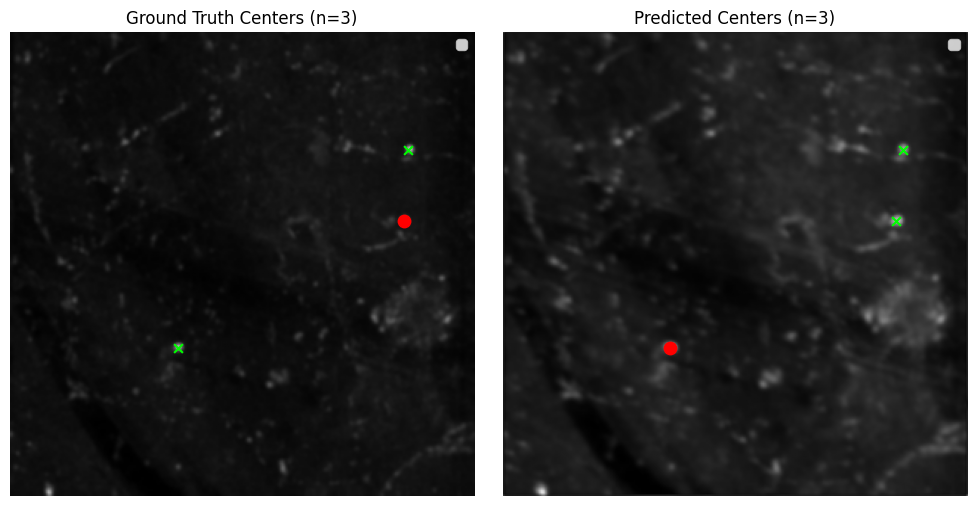

Ground truth center: (np.int64(125), np.int64(261))
Predicted center:    (np.int64(209), np.int64(111))


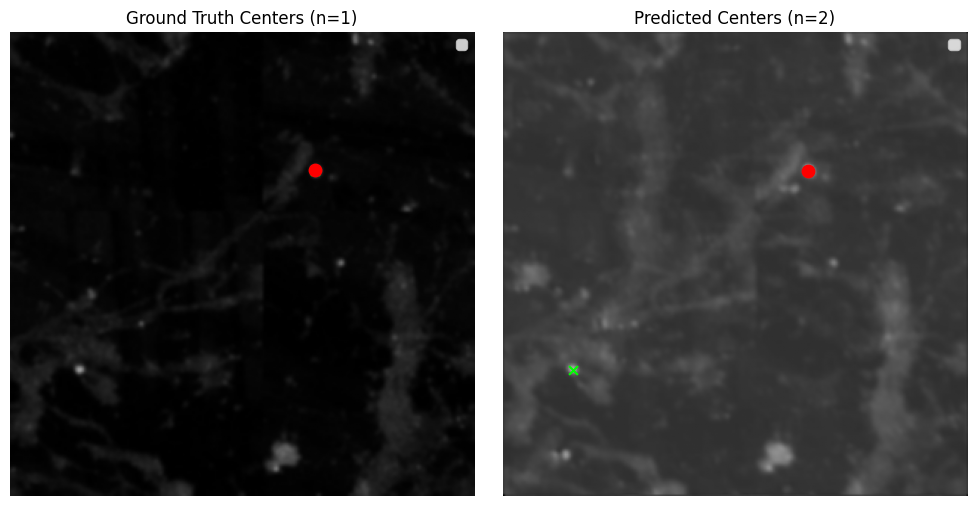

Ground truth center: (np.int64(91), np.int64(202))
Predicted center:    (np.int64(92), np.int64(202))


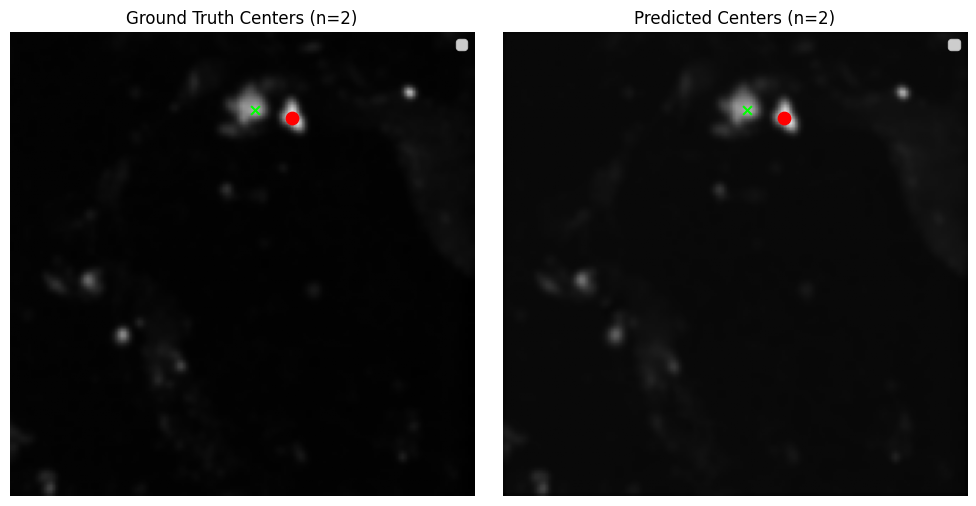

Ground truth center: (np.int64(30), np.int64(99))
Predicted center:    (np.int64(30), np.int64(99))


In [7]:
print("== Training exp1==")
model = TinyCNN(K).to(DEVICE)
model_cnn_exp1 = train(model,arr_train=arr_2d_exp1, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict exp1==")
pred_cnn_exp1 = predict_final_frame(model_cnn_exp1, arr_2d_exp1, K=K)

print("== Training exp2==")
model = TinyCNN(K).to(DEVICE)
model_cnn_exp2 = train(model,arr_train=arr_2d_exp2, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict exp2==")
pred_cnn_exp2 = predict_final_frame(model_cnn_exp2, arr_2d_exp2, K=K)

print("== Training exp3==")
model = TinyCNN(K).to(DEVICE)
model_cnn_exp3 = train(model,arr_train=arr_2d_exp3, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict exp3==")
pred_cnn_exp3 = predict_final_frame(model_cnn_exp3, arr_2d_exp3, K=K)

gt_c, pr_c_cnn, gt_pt, pr_pt_cnn = plot_centers_with_brightest(gt_exp1, pred_cnn_exp1)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt_cnn}")
gt_c, pr_c_cnn, gt_pt, pr_pt_cnn = plot_centers_with_brightest(gt_exp2, pred_cnn_exp2)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt_cnn}")
gt_c, pr_c_cnn, gt_pt, pr_pt_cnn = plot_centers_with_brightest(gt_exp3, pred_cnn_exp3)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt_cnn}")

== Training LSTM exp1 ==
Epoch 05  train 0.00010504  val 0.00008177
Epoch 10  train 0.00005698  val 0.00006232
Epoch 15  train 0.00005619  val 0.00006142
Epoch 20  train 0.00005641  val 0.00006101
Epoch 25  train 0.00005615  val 0.00006090
Epoch 30  train 0.00005565  val 0.00006101
Epoch 35  train 0.00005551  val 0.00006096
Epoch 40  train 0.00005540  val 0.00006068
Epoch 45  train 0.00005749  val 0.00006283
Epoch 50  train 0.00005562  val 0.00006178
== Predict LSTM exp1 ==
== Training LSTM exp2 ==
Epoch 05  train 0.00022914  val 0.00021931
Epoch 10  train 0.00018997  val 0.00019912
Epoch 15  train 0.00019425  val 0.00020774
Epoch 20  train 0.00018747  val 0.00019503
Epoch 25  train 0.00018791  val 0.00019320
Epoch 30  train 0.00018878  val 0.00019467
Epoch 35  train 0.00018654  val 0.00019184
Epoch 40  train 0.00019114  val 0.00019833
Epoch 45  train 0.00019711  val 0.00020559
Epoch 50  train 0.00019301  val 0.00019322
== Predict LSTM exp2 ==
== Training LSTM exp3 ==
Epoch 05  train 0

/tmp/ipython-input-2620946505.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')
/tmp/ipython-input-2620946505.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='upper right')


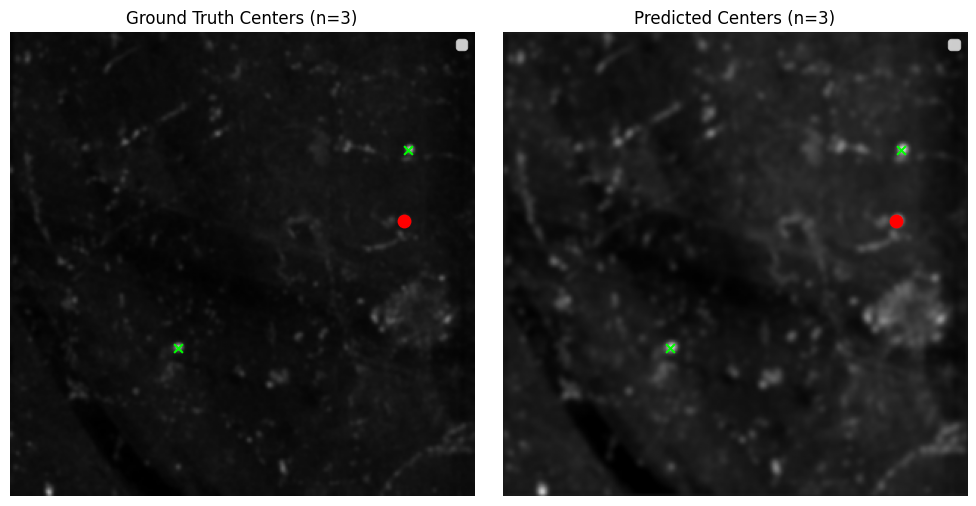

Ground truth center: (np.int64(125), np.int64(261))
Predicted center:    (np.int64(125), np.int64(261))


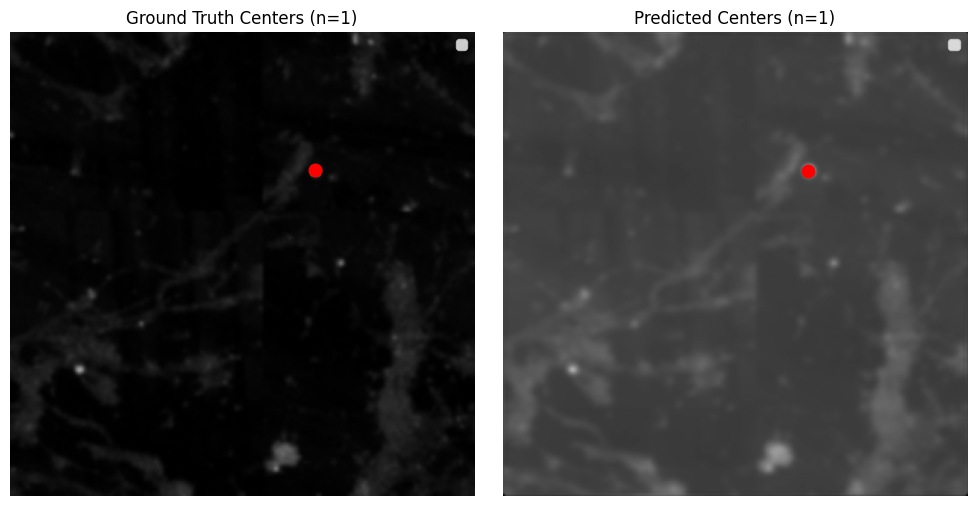

Ground truth center: (np.int64(91), np.int64(202))
Predicted center:    (np.int64(92), np.int64(202))


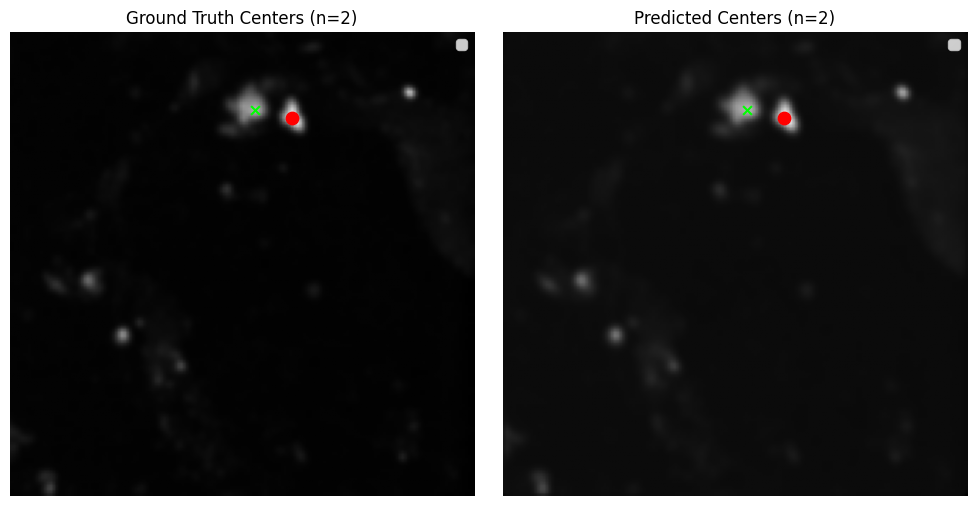

Ground truth center: (np.int64(30), np.int64(99))
Predicted center:    (np.int64(30), np.int64(99))


In [8]:
print("== Training LSTM exp1 ==")
model = SpatialLSTM(K).to(DEVICE)
model_lstm_exp1 = train(model, arr_train=arr_2d_exp1, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict LSTM exp1 ==")
pred_lstm_exp1 = predict_final_frame(model_lstm_exp1, arr_2d_exp1, K=K)

print("== Training LSTM exp2 ==")
model = SpatialLSTM(K).to(DEVICE)
model_lstm_exp2 = train(model, arr_train=arr_2d_exp2, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict LSTM exp2 ==")
pred_lstm_exp2 = predict_final_frame(model_lstm_exp2, arr_2d_exp2, K=K)

print("== Training LSTM exp3 ==")
model = SpatialLSTM(K).to(DEVICE)
model_lstm_exp3 = train(model, arr_train=arr_2d_exp3, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict LSTM exp3 ==")
pred_lstm_exp3 = predict_final_frame(model_lstm_exp3, arr_2d_exp3, K=K)

gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp1, pred_lstm_exp1)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")
gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp2, pred_lstm_exp2)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")
gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp3, pred_lstm_exp3)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")

== Training Transformer exp1 ==
Epoch 05  train 0.00030070  val 0.00032597
Epoch 10  train 0.00019883  val 0.00023081
Epoch 15  train 0.00009101  val 0.00009341
Epoch 20  train 0.00008027  val 0.00008977
Epoch 25  train 0.00007253  val 0.00007814
Epoch 30  train 0.00006750  val 0.00008108
Epoch 35  train 0.00006477  val 0.00007776
Epoch 40  train 0.00006295  val 0.00008501
Epoch 45  train 0.00006135  val 0.00008475
Epoch 50  train 0.00006049  val 0.00008439
== Predict Transformer exp1 ==
== Training Transformer exp2 ==
Epoch 05  train 0.00021710  val 0.00019992
Epoch 10  train 0.00020027  val 0.00019608
Epoch 15  train 0.00019495  val 0.00020032
Epoch 20  train 0.00019798  val 0.00020595
Epoch 25  train 0.00019527  val 0.00019608
Epoch 30  train 0.00019356  val 0.00019697
Epoch 35  train 0.00020019  val 0.00019674
Epoch 40  train 0.00019351  val 0.00019688
Epoch 45  train 0.00021367  val 0.00024200
Epoch 50  train 0.00019140  val 0.00021530
== Predict Transformer exp2 ==
== Training Tr

/tmp/ipython-input-2620946505.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')
/tmp/ipython-input-2620946505.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='upper right')


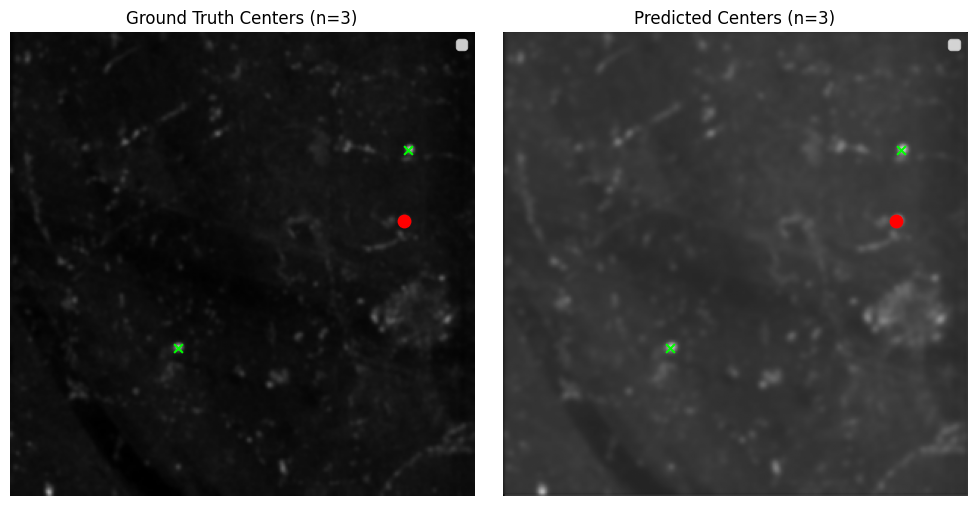

Ground truth center: (np.int64(125), np.int64(261))
Predicted center:    (np.int64(125), np.int64(261))


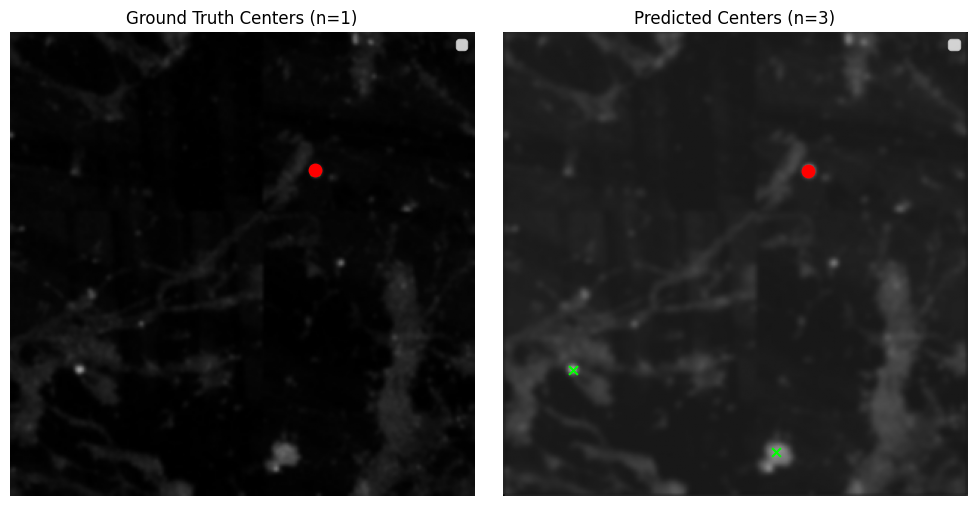

Ground truth center: (np.int64(91), np.int64(202))
Predicted center:    (np.int64(92), np.int64(202))


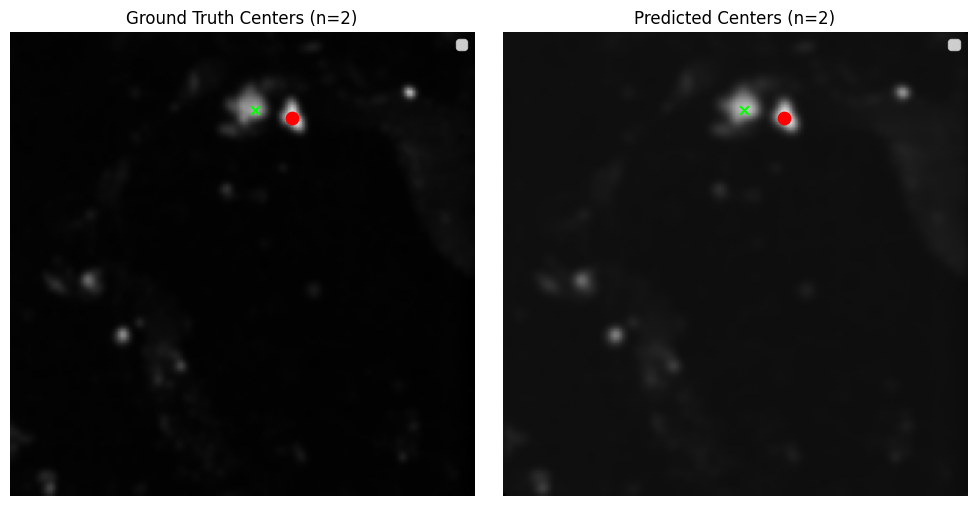

Ground truth center: (np.int64(30), np.int64(99))
Predicted center:    (np.int64(30), np.int64(99))


In [9]:
print("== Training Transformer exp1 ==")
model = SpatialTransformer(K).to(DEVICE)
model_trans_exp1 = train(model, arr_train=arr_2d_exp1, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict Transformer exp1 ==")
pred_trans_exp1 = predict_final_frame(model_trans_exp1, arr_2d_exp1, K=K)


print("== Training Transformer exp2 ==")
model = SpatialTransformer(K).to(DEVICE)
model_trans_exp2 = train(model, arr_train=arr_2d_exp2, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict Transformer exp2 ==")
pred_trans_exp2 = predict_final_frame(model_trans_exp2, arr_2d_exp2, K=K)


print("== Training Transformer exp3 ==")
model = SpatialTransformer(K).to(DEVICE)
model_trans_exp3 = train(model, arr_train=arr_2d_exp3, K=K, batch_size=8, epochs=50, lr=1e-3)
print("== Predict Transformer exp3 ==")
pred_trans_exp3 = predict_final_frame(model_trans_exp3, arr_2d_exp3, K=K)


gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp1, pred_trans_exp1)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")
gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp2, pred_trans_exp2)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")
gt_c, pr_c, gt_pt, pr_pt = plot_centers_with_brightest(gt_exp3, pred_trans_exp3)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt}")


### Metrics

First, we evaluate model performance using the following four metrics:

- **Center error (μm):** the Euclidean distance between the predicted center and the ground-truth center.  
- **AUROC:** the AUC computed between the predicted final-frame map and the true final frame, reflecting their rank-order consistency.  
- **Average Precision:** measures how well the model distinguishes bright and dark regions in the final frame in a manner consistent with the ground truth.
- **Time-to-aggregation error:** If the model cannot accurately predict the final aggregation center in one step, it continues rolling forward to make further predictions. This metric measures how many frames it needs to predict until the estimated center becomes accurate (i.e., the distance to the true center is below a threshold).

For each model, we train and test it **10 independent times**, and report the **mean ± CI** for all metrics to assess both performance and stability.


In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import t

def get_brightest_point(img):
    y, x = np.unravel_index(np.argmax(img), img.shape)
    return np.array([y, x])

def euclidean_dist(a, b):
    return np.sqrt(((np.array(a) - np.array(b))**2).sum())

def compute_center_error(preds, gt, pixel_size_um=2):
    gt_center = get_brightest_point(gt)
    errors = []
    for pred in preds:
        pred_center = get_brightest_point(pred)
        d_pix = euclidean_dist(pred_center, gt_center)
        errors.append(d_pix * pixel_size_um)
    return np.mean(errors)

def compute_spatial_quality(preds, gt, thr=0.5):
    gt_bin = (gt > thr * gt.max()).astype(int).ravel()
    aurocs, aps = [], []
    for pred in preds:
        p = (pred - pred.min()) / (pred.max() - pred.min() + 1e-6)
        p = p.ravel()
        aurocs.append(roc_auc_score(gt_bin, p))
        aps.append(average_precision_score(gt_bin, p))
    return np.mean(aurocs), np.mean(aps)

def run_once(model_class, arr_2d, K, epochs=30):
    model = model_class(K).to(DEVICE)
    model_trained = train(model, arr_train=arr_2d, K=K, batch_size=8, epochs=epochs, lr=1e-3)
    pred = predict_final_frame(model_trained, arr_2d, K=K)
    return pred

def evaluate_model(model_class, name, arr_2d, K, n_runs=10):
    gt = arr_2d[-1]
    ce_list, auroc_list, ap_list = [], [], []
    trained_models = []

    for r in range(n_runs):
        print(f"=== {name} Run {r+1}/{n_runs} ===")
        model = model_class(K).to(DEVICE)
        model_trained = train(model, arr_train=arr_2d, K=K, batch_size=8, epochs=30, lr=1e-3)
        trained_models.append(model_trained)

        pred = predict_final_frame(model_trained, arr_2d, K=K)
        ce = compute_center_error([pred], gt)
        auroc, ap = compute_spatial_quality([pred], gt)
        ce_list.append(ce)
        auroc_list.append(auroc)
        ap_list.append(ap)

        print(f"Center error: {ce:.5f} µm | AUROC: {auroc:.5f} | AP: {ap:.5f}")

    results = {
        "Model": name,
        "Center error (µm)": mean_ci_str(ce_list),
        "AUROC": mean_ci_str(auroc_list),
        "Avg Precision": mean_ci_str(ap_list)
    }
    return results, trained_models


def mean_ci_str(values, confidence=0.95):
    arr = np.array(values)
    mean = np.mean(arr)
    std = np.std(arr, ddof=1)
    n = len(arr)
    se = std / np.sqrt(n)
    ci = t.ppf((1 + confidence) / 2, n - 1) * se
    return f"{mean:.5f} ± {ci:.5f}"


### Results

From the evaluation metrics shown below, it can be observed that the second experiment is relatively easier to predict, as all three models achieve small center errors and high AUROC and average precision. For the first and third experiments, the AUROC values of the three models are similar, but **the SpatialLSTM and SpatialTransformer obtain noticeably lower center errors and higher average precision**, indicating that these two proposed models are better at sequence modeling while simultaneously capturing spatial information. The standard deviations fall within a reasonable range, suggesting that all three models exhibit stable performance and that the reported metrics are meaningful and reproducible.


exp1:
| Model              | Center error (µm)     | AUROC             | Avg Precision     |
|:-------------------|:----------------------|:------------------|:------------------|
| CNN                | 172.85891 ± 129.19230 | 0.99672 ± 0.00590 | 0.72890 ± 0.15272 |
| SpatialLSTM        | 0.00000 ± 0.00000     | 0.99994 ± 0.00003 | 0.97491 ± 0.00310 |
| SpatialTransformer | 0.00000 ± 0.00000     | 0.99994 ± 0.00004 | 0.97085 ± 0.00478 |

exp2:
| Model              | Center error (µm)   | AUROC             | Avg Precision     |
|:-------------------|:--------------------|:------------------|:------------------|
| CNN                | 1.96569 ± 0.55210   | 0.99996 ± 0.00002 | 0.92263 ± 0.02522 |
| SpatialLSTM        | 2.00000 ± 0.00000   | 0.99997 ± 0.00001 | 0.94411 ± 0.01103 |
| SpatialTransformer | 1.80000 ± 0.45243   | 0.99997 ± 0.00001 | 0.95519 ± 0.00879 |

exp3:
| Model              | Center error (µm)     | AUROC             | Avg Precision     |
|:-------------------|:----------------------|:------------------|:------------------|
| CNN                | 241.08602 ± 118.35292 | 0.99825 ± 0.00222 | 0.67730 ± 0.16814 |
| SpatialLSTM        | 0.00000 ± 0.00000     | 0.99994 ± 0.00003 | 0.97036 ± 0.00564 |
| SpatialTransformer | 57.87780 ± 130.92869  | 0.94996 ± 0.11309 | 0.87805 ± 0.22061 |

In [9]:
import torch
import os

def test_models(arr_2d,key):
  all_models = {}
  rows = []

  save_dir = "/content/drive/MyDrive/models"
  os.makedirs(save_dir, exist_ok=True)

  for model_class, name in [
      (TinyCNN, "CNN"),
      (SpatialLSTM, "SpatialLSTM"),
      (SpatialTransformer, "SpatialTransformer")
  ]:
      result, models = evaluate_model(model_class, name, arr_2d, K, n_runs=10)
      rows.append(result)
      all_models[name] = models

      save_path = os.path.join(save_dir, f"{name.replace(' ', '_')}_{key}.pt")
      torch.save(models, save_path)
      print(f"Saved {name} (10 models) to {save_path}")

  df = pd.DataFrame(rows)
  return df

df_exp1 = test_models(arr_2d_exp1,"exp1")
df_exp2 = test_models(arr_2d_exp2,"exp2")
df_exp3 = test_models(arr_2d_exp1,"exp3")
print('exp1:')
print(df_exp1.to_markdown(index=False))
print('exp2:')
print(df_exp2.to_markdown(index=False))
print('exp3:')
print(df_exp3.to_markdown(index=False))

=== CNN Run 1/10 ===
Epoch 05  train 0.00042107  val 0.00041536
Epoch 10  train 0.00013997  val 0.00013832
Epoch 15  train 0.00010428  val 0.00010884
Epoch 20  train 0.00009636  val 0.00010119
Epoch 25  train 0.00008505  val 0.00008815
Epoch 30  train 0.00006761  val 0.00007227
Center error: 2.82843 µm | AUROC: 0.99980 | AP: 0.81838
=== CNN Run 2/10 ===
Epoch 05  train 0.00054999  val 0.00047313
Epoch 10  train 0.00035674  val 0.00033909
Epoch 15  train 0.00016269  val 0.00014119
Epoch 20  train 0.00007090  val 0.00007451
Epoch 25  train 0.00006439  val 0.00006959
Epoch 30  train 0.00006100  val 0.00006663
Center error: 345.58356 µm | AUROC: 0.99907 | AP: 0.49245
=== CNN Run 3/10 ===
Epoch 05  train 0.00012826  val 0.00010001
Epoch 10  train 0.00009094  val 0.00009307
Epoch 15  train 0.00006981  val 0.00007256
Epoch 20  train 0.00005799  val 0.00006268
Epoch 25  train 0.00005486  val 0.00005977
Epoch 30  train 0.00005343  val 0.00005833
Center error: 343.83717 µm | AUROC: 0.99547 | AP:

Using 50 μm as the threshold, we evaluate the Time-to-aggregation error for the three models. For experiment 1, we observe that the SpatialLSTM and SpatialTransformer can accurately predict the aggregation center in a single step, while the CNN needs to roll forward and predict 6 additional frames before approaching the true center. This further demonstrates the accuracy and prediction efficiency of the two proposed methods.


In [23]:
#Time-to-Aggregation Error
@torch.no_grad()
def rollout_future_frames(model, arr_2d, K=8, n_future=10):
    model.eval()
    seq = arr_2d.copy()
    T, H, W = seq.shape
    preds = []
    x_curr = seq[-K:].astype(np.float32)  # (K,H,W)

    for step in range(n_future):
        x_tensor = torch.from_numpy(x_curr[None, :, None, ...]).to(DEVICE)  # (1,K,1,H,W)
        pred = model(x_tensor).cpu().squeeze().numpy()
        pred = np.clip(pred, 0, 1)
        preds.append(pred)
        x_curr = np.concatenate([x_curr[1:], pred[None, ...]], axis=0)

    return np.stack(preds, axis=0)  # (n_future, H, W)

def compute_tta_error(pred_seq, gt, pixel_size_um=2, radius_um=50):
    """
    pred_seq: [T_pred, H, W]
    gt: final ground truth frame
    """
    gt_center = get_brightest_point(gt)
    errors = []
    for t, pred in enumerate(pred_seq):
        pred_center = get_brightest_point(pred)
        dist_um = euclidean_dist(pred_center, gt_center) * pixel_size_um
        if dist_um <= radius_um:
            return t
    return len(pred_seq)

def test_tta(models,arr_2d):
    tta = {}
    print('Predicting CNN')
    pred_seq_cnn = rollout_future_frames(models[0], arr_2d, K=8, n_future=50)
    tta['CNN'] = compute_tta_error(pred_seq_cnn, gt=arr_2d[-1])

    print('Predicting LSTM')
    pred_seq_lstm = rollout_future_frames(models[1], arr_2d, K=8, n_future=50)
    tta['SpatialLSTM'] = compute_tta_error(pred_seq_lstm, gt=arr_2d[-1])

    print('Predicting Transformer')
    pred_seq_trans = rollout_future_frames(models[2],arr_2d, K=8, n_future=50)
    tta['SpatialTransformer'] = compute_tta_error(pred_seq_trans, gt=arr_2d[-1])
    print(tta)

print('exp1')
test_tta([model_cnn_exp1,model_lstm_exp1,model_trans_exp1],arr_2d_exp1)
print('exp2')
test_tta([model_cnn_exp2,model_lstm_exp2,model_trans_exp2],arr_2d_exp2)
print('exp3')
test_tta([model_cnn_exp3,model_lstm_exp3,model_trans_exp3],arr_2d_exp3)

exp1
Predicting CNN
Predicting LSTM
Predicting Transformer
{'CNN': 6, 'SpatialLSTM': 0, 'SpatialTransformer': 0}
exp2
Predicting CNN
Predicting LSTM
Predicting Transformer
{'CNN': 0, 'SpatialLSTM': 0, 'SpatialTransformer': 0}
exp3
Predicting CNN
Predicting LSTM
Predicting Transformer
{'CNN': 0, 'SpatialLSTM': 0, 'SpatialTransformer': 0}


### Ablation Studies

Next, we conduct a series of ablation studies to examine where the performance gains of our model originate.

As a starting point, we present two of the most naive ways to incorporate LSTM and Transformer architectures: the image is first encoded by a CNN, then spatially averaged into a 1D sequence, which is processed by an LSTM or Transformer for sequence modeling, and finally decoded by a CNN decoder to produce the predicted final frame.

Clearly, **this naive approach loses essential spatial information**. As shown in the visualized predictions below, the output values across the entire image are almost uniform, with no meaningful distinctions between locations. **This provides direct evidence of the importance of preserving spatial information** in the modeling process.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveLSTM(nn.Module):
    def __init__(self, K, hidden_dim=64):
        super().__init__()
        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU()
        )
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_dim, batch_first=True)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(hidden_dim, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):  # (B,K,1,H,W)
        B,K,_,H,W = x.shape
        feats = []
        for t in range(K):
            f = self.cnn_enc(x[:,t])          # (B,32,H,W)
            f = f.mean(dim=[2,3])             # (B,32)
            feats.append(f)
        feats = torch.stack(feats, dim=1)     # (B,K,32)
        lstm_out, _ = self.lstm(feats)        # (B,K,hidden_dim)
        z = lstm_out[:,-1].unsqueeze(-1).unsqueeze(-1).expand(-1,-1,H,W)
        out = self.conv_dec(z)
        return out

class NaiveTransformer(nn.Module):
    def __init__(self, K, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.cnn_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, d_model, 3, padding=1), nn.ReLU()
        )
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.conv_dec = nn.Sequential(
            nn.Conv2d(d_model, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):  # (B,K,1,H,W)
        B,K,_,H,W = x.shape
        feats = []
        for t in range(K):
            f = self.cnn_enc(x[:,t])          # (B,d_model,H,W)
            f = f.mean(dim=[2,3])             # (B,d_model)
            feats.append(f)
        feats = torch.stack(feats, dim=1)     # (B,K,d_model)
        z = self.transformer(feats)           # (B,K,d_model)
        z_last = z[:,-1].unsqueeze(-1).unsqueeze(-1).expand(-1,-1,H,W)
        out = self.conv_dec(z_last)
        return out


== Training NaiveLSTM ==
Epoch 05  train 0.00021214  val 0.00021103
Epoch 10  train 0.00021021  val 0.00021083
Epoch 15  train 0.00021010  val 0.00021023
Epoch 20  train 0.00021022  val 0.00021018
Epoch 25  train 0.00021030  val 0.00021023
Epoch 30  train 0.00021006  val 0.00021023
== Predict NaiveLSTM ==
== Training NaiveTransformer ==
Epoch 05  train 0.00065402  val 0.00044075
Epoch 10  train 0.00035559  val 0.00024503
Epoch 15  train 0.00044231  val 0.00022441
Epoch 20  train 0.00030991  val 0.00021121
Epoch 25  train 0.00026797  val 0.00021079
Epoch 30  train 0.00027521  val 0.00023816
== Predict NaiveTransformer ==


/tmp/ipython-input-437668114.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right')
/tmp/ipython-input-437668114.py:133: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='upper right')


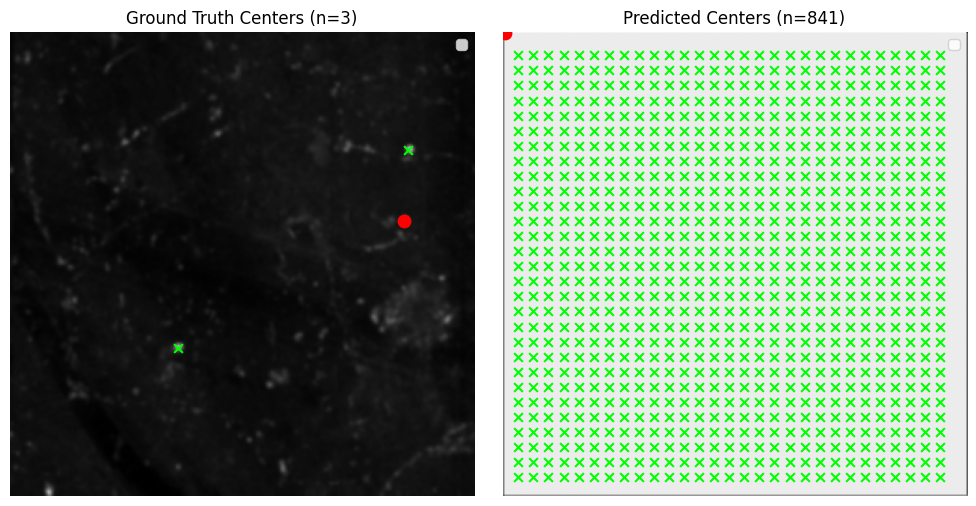

Ground truth center: [125 261]
Predicted center:    (np.int64(125), np.int64(261))


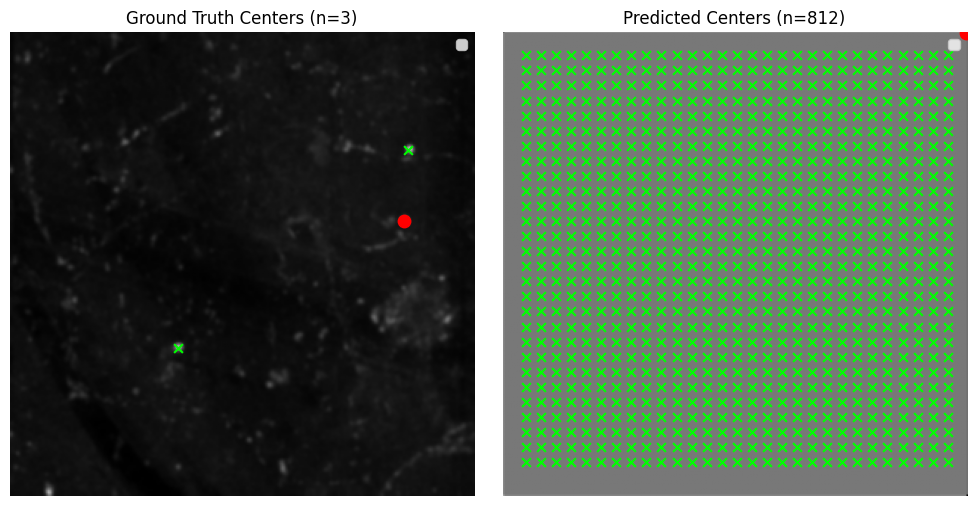

Ground truth center: [125 261]
Predicted center:    [  0 307]
| Model              |   Center error (µm) |   AUROC |   Avg Precision |
|:-------------------|--------------------:|--------:|----------------:|
| CNN                |             414.324 | 0.99986 |         0.80376 |
| SpatialLSTM        |               0     | 0.9999  |         0.96736 |
| SpatialTransformer |               0     | 0.99996 |         0.97846 |
| NaiveLSTM          |             695.255 | 0.49456 |         0.0006  |
| NaiveTransformer   |             321.001 | 0.50546 |         0.00061 |


In [ ]:

print("== Training NaiveLSTM ==")
model = NaiveLSTM(K).to(DEVICE)
model_lstm2 = train(model, arr_train=arr_2d_exp1, K=K, batch_size=8, epochs=30, lr=1e-3)

print("== Predict NaiveLSTM ==")
pred_lstm2 = predict_final_frame(model_lstm2, arr_2d_exp1, K=K)

print("== Training NaiveTransformer ==")
model = NaiveTransformer(K).to(DEVICE)
model_trans2 = train(model,arr_train=arr_2d_exp1, K=K, batch_size=8, epochs=30, lr=1e-3)

print("== Predict NaiveTransformer ==")
pred_trans2 = predict_final_frame(model_trans2, arr_2d_exp1, K=K)

gt_c, pr_c_lstm2, gt_pt, pr_pt_lstm2 = plot_centers_with_brightest(gt_exp1, pred_lstm2)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt_lstm2}")

gt_c, pr_c_tr2, gt_pt,pr_pt_tr2 = plot_centers_with_brightest(gt_exp1, pred_trans2)
print(f"Ground truth center: {gt_pt}")
print(f"Predicted center:    {pr_pt_tr2}")

preds_all = {
    "CNN": [pred_cnn_exp1],
    "SpatialLSTM": [pred_lstm_exp1],
    "SpatialTransformer": [pred_trans_exp1],
    "NaiveLSTM": [pred_lstm2],
    "NaiveTransformer": [pred_trans2],
}

gt = arr_2d_exp1[-1]
rows = []
for name, preds in preds_all.items():
    center_err = compute_center_error(preds, gt)
    auroc, ap = compute_spatial_quality(preds, gt)
    rows.append({
        "Model": name,
        "Center error (µm)": f"{center_err:.5f}",
        "AUROC": f"{auroc:.5f}",
        "Avg Precision": f"{ap:.5f}"
    })

df = pd.DataFrame(rows)
print(df.to_markdown(index=False))

We then perform a more systematic set of ablation studies. For both the SpatialLSTM and SpatialTransformer, we remove the fusion operation with the last input frame (i.e., the second-to-last frame of the full sequence) to examine the importance of retaining the most recent information. For the SpatialTransformer, we additionally ablate the positional embedding to evaluate its contribution.

As before, each ablated model is trained and tested 10 times, and the table below reports the mean and standard deviation of all evaluation metrics.

exp1:
| Model                         | Center error (µm)     | AUROC             | Avg Precision     |
|:------------------------------|:----------------------|:------------------|:------------------|
| CNN                           | 172.85891 ± 129.19230 | 0.99672 ± 0.00590 | 0.72890 ± 0.15272 |
| SpatialLSTM                   | 0.00000 ± 0.00000     | 0.99994 ± 0.00003 | 0.97491 ± 0.00310 |
| SpatialTransformer            | 0.00000 ± 0.00000     | 0.99994 ± 0.00004 | 0.97085 ± 0.00478 |
| LSTM (w/o last fusion)        | 300.87796 ± 104.19917 | 0.85693 ± 0.01154 | 0.00225 ± 0.00018 |
| NaiveLSTM                     | 562.51884 ± 48.90400  | 0.50070 ± 0.00417 | 0.00061 ± 0.00002 |
| Transformer (w/o last fusion) | 265.64254 ± 123.45116 | 0.51424 ± 0.12247 | 0.00103 ± 0.00044 |
| Transformer (w/o time pos)    | 0.00000 ± 0.00000     | 0.99993 ± 0.00003 | 0.97208 ± 0.00683 |
| NaiveTransformer              | 531.36648 ± 82.53641  | 0.49590 ± 0.00287 | 0.00060 ± 0.00001 |

exp2:
| Model                         | Center error (µm)     | AUROC             | Avg Precision     |
|:------------------------------|:----------------------|:------------------|:------------------|
| CNN                           | 172.85891 ± 129.19230 | 0.99672 ± 0.00590 | 0.72890 ± 0.15272 |
| SpatialLSTM                   | 0.00000 ± 0.00000     | 0.99994 ± 0.00003 | 0.97491 ± 0.00310 |
| SpatialTransformer            | 0.00000 ± 0.00000     | 0.99994 ± 0.00004 | 0.97085 ± 0.00478 |
| LSTM (w/o last fusion)        | 408.85139 ± 54.08897  | 0.87300 ± 0.02333 | 0.00308 ± 0.00078 |
| NaiveLSTM                     | 447.27927 ± 54.34859  | 0.50130 ± 0.00478 | 0.00040 ± 0.00000 |
| Transformer (w/o last fusion) | 411.95848 ± 73.72231  | 0.58245 ± 0.17711 | 0.00142 ± 0.00159 |
| Transformer (w/o time pos)    | 1.68284 ± 0.66084     | 0.99997 ± 0.00001 | 0.95068 ± 0.01542 |
| NaiveTransformer              | 459.45068 ± 63.10960  | 0.50130 ± 0.00292 | 0.00040 ± 0.00000 |

exp3:
| Model                         | Center error (µm)     | AUROC             | Avg Precision     |
|:------------------------------|:----------------------|:------------------|:------------------|
| CNN                           | 172.85891 ± 129.19230 | 0.99672 ± 0.00590 | 0.72890 ± 0.15272 |
| SpatialLSTM                   | 0.00000 ± 0.00000     | 0.99994 ± 0.00003 | 0.97491 ± 0.00310 |
| SpatialTransformer            | 0.00000 ± 0.00000     | 0.99994 ± 0.00004 | 0.97085 ± 0.00478 |
| LSTM (w/o last fusion)        | 1.60000 ± 0.60324     | 0.99411 ± 0.00072 | 0.90408 ± 0.02008 |
| NaiveLSTM                     | 205.34034 ± 0.87496   | 0.50972 ± 0.00226 | 0.00334 ± 0.00001 |
| Transformer (w/o last fusion) | 219.63146 ± 67.57260  | 0.89877 ± 0.13952 | 0.08363 ± 0.03610 |
| Transformer (w/o time pos)    | 0.00000 ± 0.00000     | 0.99994 ± 0.00002 | 0.98406 ± 0.00432 |
| NaiveTransformer              | 237.31214 ± 48.69655  | 0.50486 ± 0.00341 | 0.00333 ± 0.00001 |

From the results, we observe that **removing the fusion with the most recent frame leads to a clear drop in performance** across all three experiments (though still better than the naive approaches described earlier). This demonstrates the importance of reinforcing the most recent temporal information when predicting future frames. The performance of the SpatialTransformer **does not change significantly after ablating positional embeddings**, which may be due to the relatively short sequence length or the possibility that positional information is not effectively learned (perhaps overshadowed by stronger cues). This suggests a potential direction for future improvement.


In [24]:
from functools import partial
import torch, os
import re

def add_ablations(arr_2d,key):
    save_dir = "/content/drive/MyDrive/models"
    # os.makedirs(save_dir, exist_ok=True)

    new_rows = []
    ablation_models = [
        ("LSTM (w/o last fusion)", partial(SpatialLSTM, fuse_last_frame=False)),
        ("NaiveLSTM", NaiveLSTM),
        ("Transformer (w/o last fusion)", partial(SpatialTransformer, fuse_last_frame=False)),
        ("Transformer (w/o time pos)", partial(SpatialTransformer, use_time_pos=False)),
        ("NaiveTransformer", NaiveTransformer),
    ]

    for name, model_class in ablation_models:
        result, models = evaluate_model(model_class, name, arr_2d, K, n_runs=10)
        new_rows.append(result)
        safe_name = re.sub(r'[\\/*?:"<>|()\[\] ]', '_', name)
        save_path = os.path.join(save_dir, f"{safe_name}_{key}.pt")
        torch.save(models, save_path)
        print(f"Saved {name} (10 models) to {save_dir}/{name.replace(' ', '_')}.pt")
    return new_rows

new_rows_exp1 = add_ablations(arr_2d_exp1,"exp1")
new_rows_exp2 = add_ablations(arr_2d_exp2,"exp2")
new_rows_exp3 = add_ablations(arr_2d_exp3,"exp3")

df_exp1_new = pd.concat([df_exp1, pd.DataFrame(new_rows_exp1)], ignore_index=True)
df_exp2_new = pd.concat([df_exp1, pd.DataFrame(new_rows_exp2)], ignore_index=True)
df_exp3_new = pd.concat([df_exp1, pd.DataFrame(new_rows_exp3)], ignore_index=True)
print('exp1:')
print(df_exp1_new.to_markdown(index=False))
print('exp2:')
print(df_exp2_new.to_markdown(index=False))
print('exp3:')
print(df_exp3_new.to_markdown(index=False))


=== LSTM (w/o last fusion) Run 1/10 ===
Epoch 05  train 0.00039922  val 0.00037096
Epoch 10  train 0.00024075  val 0.00023501
Epoch 15  train 0.00021632  val 0.00021143
Epoch 20  train 0.00018438  val 0.00017957
Epoch 25  train 0.00016456  val 0.00015975
Epoch 30  train 0.00015492  val 0.00015219
Center error: 372.23648 µm | AUROC: 0.86676 | AP: 0.00249
=== LSTM (w/o last fusion) Run 2/10 ===
Epoch 05  train 0.00019222  val 0.00018076
Epoch 10  train 0.00016285  val 0.00016008
Epoch 15  train 0.00015583  val 0.00015274
Epoch 20  train 0.00015058  val 0.00014963
Epoch 25  train 0.00014712  val 0.00014581
Epoch 30  train 0.00014491  val 0.00014476
Center error: 384.84283 µm | AUROC: 0.88435 | AP: 0.00269
=== LSTM (w/o last fusion) Run 3/10 ===
Epoch 05  train 0.00039866  val 0.00033958
Epoch 10  train 0.00024929  val 0.00024229
Epoch 15  train 0.00021539  val 0.00021216
Epoch 20  train 0.00018833  val 0.00018219
Epoch 25  train 0.00016572  val 0.00017107
Epoch 30  train 0.00015674  val 0

Based on the previous analysis, we found that incorporating the most recent information is crucial for accurate future prediction. This naturally raises a question: **is the model simply copying the most recent frame rather than learning the actual temporal evolution of the sequence?**

To address this concern, we tested a simple baseline that directly uses the second-to-last frame to predict the final frame. The resulting metrics are far worse than those of the proposed models (especially for experiments 1 and 2). This indicates that our models not only preserve the most recent information but also **successfully learn the temporal dynamics across historical frames**, jointly guiding more accurate future predictions.


In [25]:
def pred_with_last_frame(arr_2d):
    gt = arr_2d[-1]
    pred_dummy = arr_2d[-2]
    center_err = compute_center_error([pred_dummy], gt)
    auroc, ap = compute_spatial_quality([pred_dummy], gt)

    print("=== Using last frame as prediction ===")
    print(f"Center error (µm): {center_err:.5f}")
    print(f"AUROC: {auroc:.5f}")
    print(f"Avg Precision: {ap:.5f}")

print('exp1:')
pred_with_last_frame(arr_2d_exp1)
print('exp2:')
pred_with_last_frame(arr_2d_exp2)
print('exp3:')
pred_with_last_frame(arr_2d_exp3)


exp1:
=== Using last frame as prediction ===
Center error (µm): 4.47214
AUROC: 0.91069
Avg Precision: 0.11767
exp2:
=== Using last frame as prediction ===
Center error (µm): 496.55614
AUROC: 0.85653
Avg Precision: 0.00217
exp3:
=== Using last frame as prediction ===
Center error (µm): 0.00000
AUROC: 0.99954
Avg Precision: 0.96496


 ### Robustness check

 To assess the robustness of our results, we evaluate the trained models on subsampled test data and compute the relative drop for each metric. As shown in the table below, both the **SpatialLSTM and SpatialTransformer exhibit smaller performance drops compared to the CNN**, indicating that these two models not only achieve higher predictive accuracy but also demonstrate greater stability under resolution degradation.

 Reduced proportion of metrics (increased proportion for center error):

exp1:
| Model              |   Center error (µm) |        AUROC |   Avg Precision |
|:-------------------|--------------------:|-------------:|----------------:|
| CNN                |             -1.8552 | -0.000561843 |    -0.0327205   |
| SpatialLSTM        |             -0      |  5.0003e-05  |     0.00184632  |
| SpatialTransformer |             -0      |  4.00024e-05 |    -0.000175104 |

exp2:
| Model              |   Center error (µm) |        AUROC |   Avg Precision |
|:-------------------|--------------------:|-------------:|----------------:|
| CNN                |            0.186036 | -0.000460018 |      -0.286648  |
| SpatialLSTM        |            0.092895 | -6.00018e-05 |      -0.0290962 |
| SpatialTransformer |           -0.184094 | -7.00021e-05 |      -0.0525026 |

exp3:
| Model              |   Center error (µm) |        AUROC |   Avg Precision |
|:-------------------|--------------------:|-------------:|----------------:|
| CNN                |          -8.4142    | -0.000930316 |      -0.184788  |
| SpatialLSTM        |          -1.66667   | -0.000120022 |      -0.0604431 |
| SpatialTransformer |          -0.0778266 | -0.000115808 |      -0.0585155 |


In [26]:
import torch, os, numpy as np, pandas as pd
from scipy.stats import t

def load_model_and_eval(arr_test,key):
    print(key)
    gt_test = arr_test[-1]

    def mean_ci(values, confidence=0.95):
        arr = np.array(values, dtype=float)
        n = len(arr)
        mean = arr.mean()
        se = arr.std(ddof=1) / np.sqrt(n)
        ci = t.ppf((1 + confidence) / 2, n - 1) * se
        return f"{mean:.5f} ± {ci:.5f}"

    save_dir = "/content/drive/MyDrive/models"
    loaded_models = {}
    for fname in os.listdir(save_dir):
        if fname.endswith(".pt") and (key in fname):
            path = os.path.join(save_dir, fname)
            models = torch.load(path, map_location=DEVICE, weights_only=False)
            name = fname.split("_exp")[0].replace("_", " ")
            loaded_models[name] = models
            print(f"Loaded {len(models)} models from {fname}")

    rows = []
    for name, model_list in loaded_models.items():
        ce_list, auroc_list, ap_list = [], [], []
        print(f"\n== Evaluating {name} ==")
        for i, model in enumerate(model_list):
            pred = predict_final_frame(model, arr_test, K=K)
            ce = compute_center_error([pred], gt_test)
            auroc, ap = compute_spatial_quality([pred], gt_test)
            ce_list.append(ce)
            auroc_list.append(auroc)
            ap_list.append(ap)
            print(f"  run {i+1:02d}: CE={ce:.4f}  AUROC={auroc:.4f}  AP={ap:.4f}")

        rows.append({
            "Model": name,
            "Center error (µm)": mean_ci(ce_list),
            "AUROC": mean_ci(auroc_list),
            "Avg Precision": mean_ci(ap_list)
        })

    df_test = pd.DataFrame(rows)
    return df_test


def check_reduce(df,df_sub):
    cols = ["Center error (µm)", "AUROC", "Avg Precision"]
    models = ["CNN", "SpatialLSTM", "SpatialTransformer"]
    df = df[df["Model"].isin(models)].reset_index(drop=True)
    df_sub = df_sub[df_sub["Model"].isin(models)].reset_index(drop=True)

    def extract_mean(x):
        try:
            return float(str(x).split("±")[0].strip())
        except:
            return np.nan

    for c in cols:
        df[c] = df[c].apply(extract_mean)
        df_sub[c] = df_sub[c].apply(extract_mean)

    df_diff = df_sub.copy()
    for c in cols:
        df_diff[c] = (df_sub[c] - df[c]) / (df[c] + 1e-9)
        if c == "Center error (µm)":
            df_diff[c] = -df_diff[c]

    df_diff["Model"] = df_sub["Model"]
    return df_diff


path1 = '/content/drive/MyDrive/processed/2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled_preproc.npy'
path2 = '/content/drive/MyDrive/processed/2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled_preproc.npy'
path3 = '/content/drive/MyDrive/processed/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled_preproc.npy'
arr_sub_exp1,arr_sub_exp2,arr_sub_exp3 = np.load(path1),np.load(path2),np.load(path3)

df_exp1 = load_model_and_eval(arr_2d_exp1,'exp1')
df_exp2 = load_model_and_eval(arr_2d_exp2,'exp2')
df_exp3 = load_model_and_eval(arr_2d_exp3,'exp3')

df_sub_exp1 = load_model_and_eval(arr_sub_exp1,'exp1')
df_sub_exp2 = load_model_and_eval(arr_sub_exp2,'exp2')
df_sub_exp3 = load_model_and_eval(arr_sub_exp3,'exp3')

print('test on full data:')
print('exp1:')
print(df_exp1.to_markdown(index=False))
print('exp2:')
print(df_exp2.to_markdown(index=False))
print('exp3:')
print(df_exp3.to_markdown(index=False))

print('test on subset:')
print('exp1:')
print(df_sub_exp1.to_markdown(index=False))
print('exp2:')
print(df_sub_exp2.to_markdown(index=False))
print('exp3:')
print(df_sub_exp3.to_markdown(index=False))

df_diff_exp1 = check_reduce(df_exp1,df_sub_exp1)
df_diff_exp2 = check_reduce(df_exp2,df_sub_exp2)
df_diff_exp3 = check_reduce(df_exp3,df_sub_exp3)
print("Reduced proportion (increased proportion for center error):")
print('exp1:')
print(df_diff_exp1.to_markdown(index=False))
print('exp2:')
print(df_diff_exp2.to_markdown(index=False))
print('exp3:')
print(df_diff_exp3.to_markdown(index=False))


exp1
Loaded 10 models from CNN_exp1.pt
Loaded 10 models from SpatialLSTM_exp1.pt
Loaded 10 models from SpatialTransformer_exp1.pt
Loaded 10 models from LSTM__w_o_last_fusion__exp1.pt
Loaded 10 models from NaiveLSTM_exp1.pt
Loaded 10 models from Transformer__w_o_last_fusion__exp1.pt
Loaded 10 models from Transformer__w_o_time_pos__exp1.pt
Loaded 10 models from NaiveTransformer_exp1.pt

== Evaluating CNN ==
  run 01: CE=2.8284  AUROC=0.9998  AP=0.8184
  run 02: CE=345.5836  AUROC=0.9991  AP=0.4925
  run 03: CE=343.8372  AUROC=0.9955  AP=0.5565
  run 04: CE=0.0000  AUROC=0.9999  AP=0.9095
  run 05: CE=2.8284  AUROC=0.9997  AP=0.6985
  run 06: CE=2.0000  AUROC=0.9999  AP=0.8842
  run 07: CE=343.8372  AUROC=0.9999  AP=0.8376
  run 08: CE=343.8372  AUROC=0.9736  AP=0.2945
  run 09: CE=0.0000  AUROC=0.9999  AP=0.9179
  run 10: CE=343.8372  AUROC=0.9999  AP=0.8795

== Evaluating SpatialLSTM ==
  run 01: CE=0.0000  AUROC=0.9999  AP=0.9642
  run 02: CE=0.0000  AUROC=1.0000  AP=0.9788
  run 03: C

In addition to final-frame prediction, we also visualize the outputs of the three models for early frames and highlight the brightest centers. **In the early stages, the Dicty cells have not yet fully aggregated, and the centers are less distinctive** (sometimes with multiple regions of similar brightness), making the predictions more prone to deviation. As aggregation progresses, the centers become increasingly distinct, and the predicted centers correspondingly become more accurate.


CNN


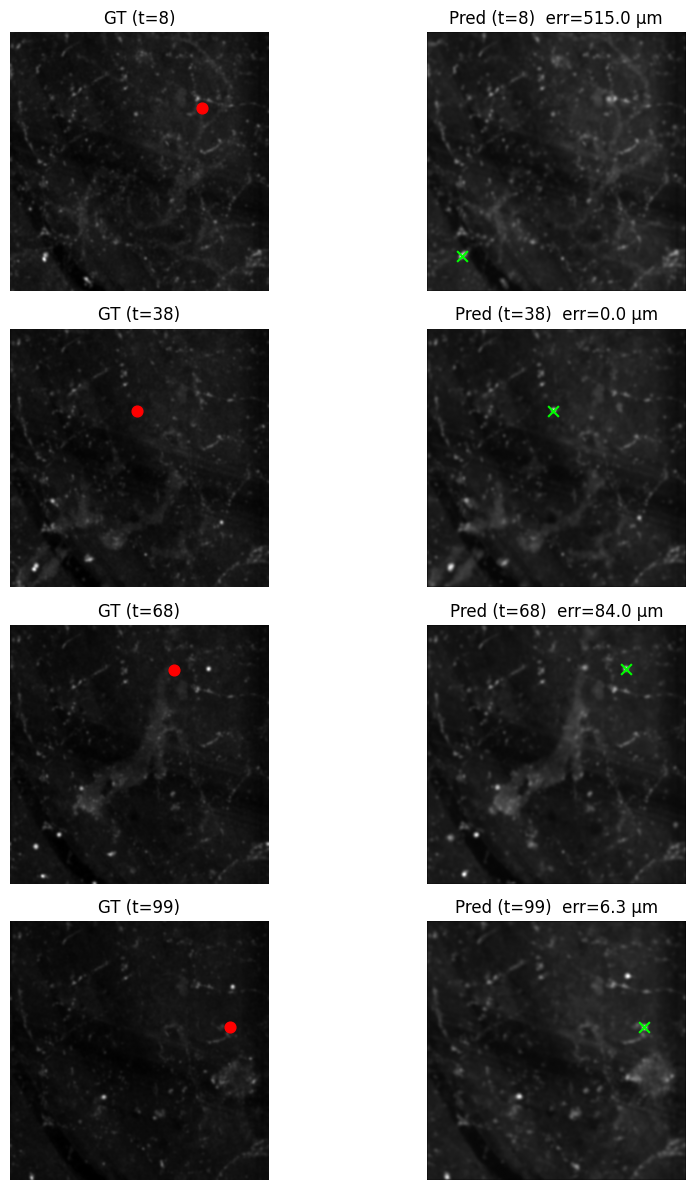

SpatialLSTM


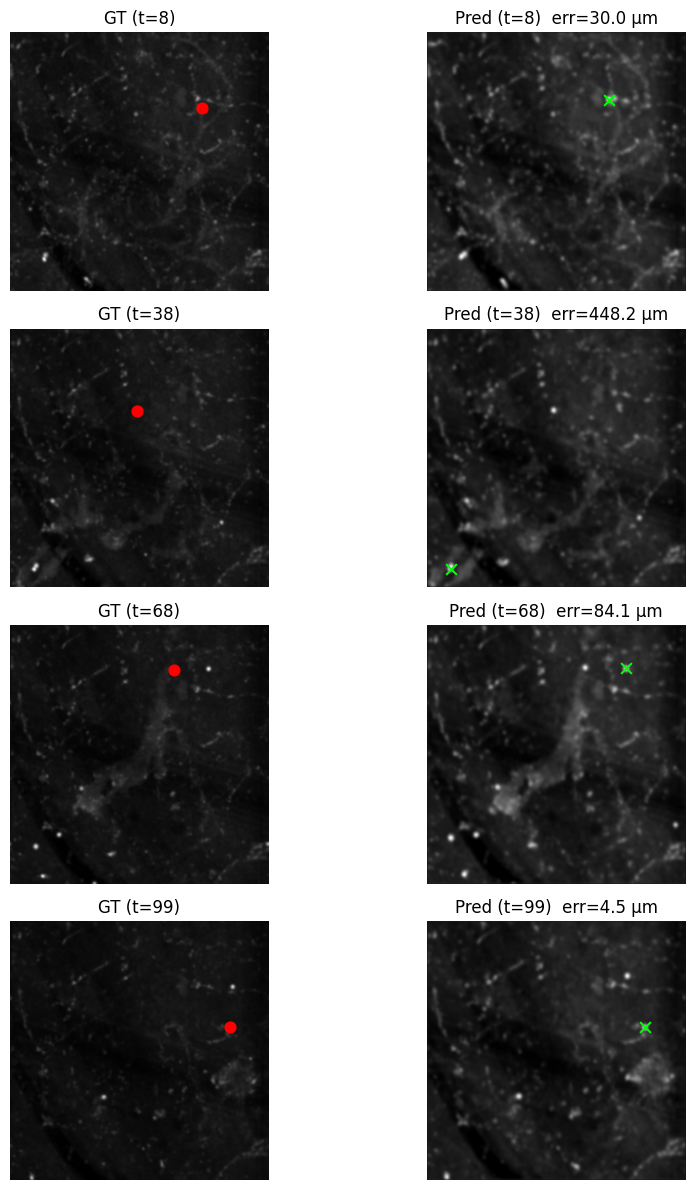

SpatialTransformer


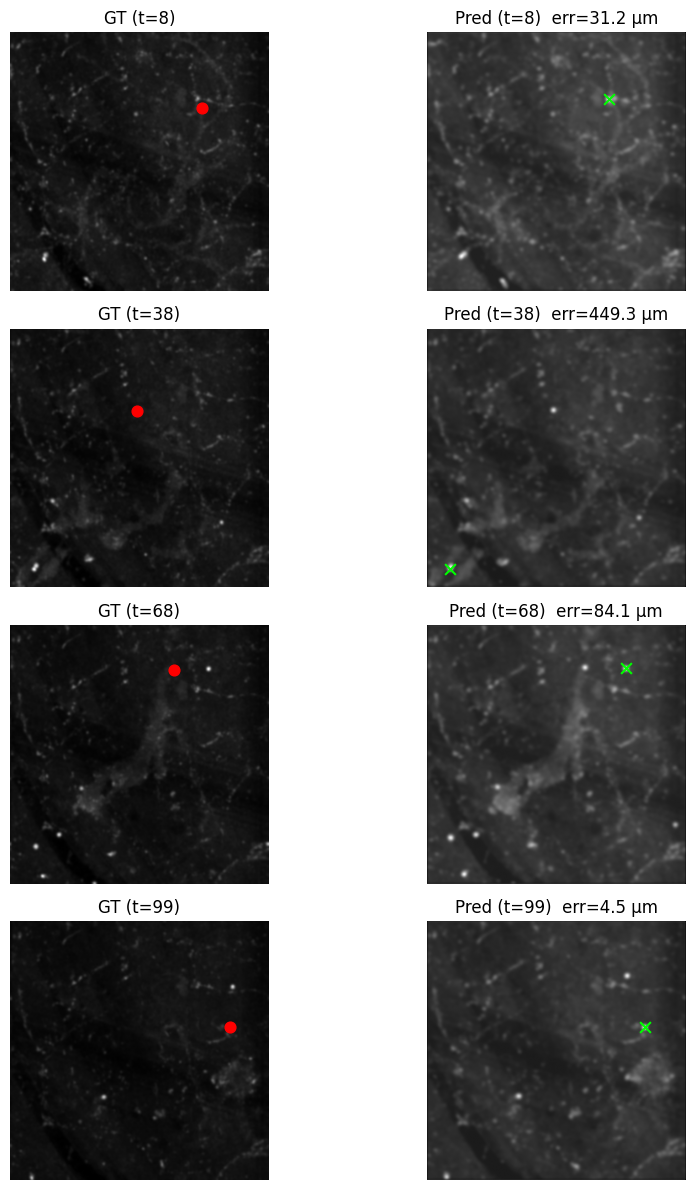

In [27]:
# "Early frames with predicted hotspot/center overlayed"
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_multi_frame_predictions(arr_2d, model, K=8, n_pred=4, thr=0.7, pixel_size_um=2):
    T = arr_2d.shape[0]
    time_points = np.linspace(K, T-1, n_pred, dtype=int)
    gt_final = arr_2d[-1]
    gt_final_center = get_brightest_point(gt_final)

    fig, axs = plt.subplots(n_pred, 2, figsize=(10, 3*n_pred))
    if n_pred == 1:
        axs = axs[None, :]

    for i, t in enumerate(time_points):
        if t < K:
            continue

        x = arr_2d[t-K:t]
        x = x[:, None, ...]
        x = torch.from_numpy(x[None].astype(np.float32)).to(DEVICE)
        with torch.no_grad():
            pred = model(x).detach().cpu().squeeze().numpy()
        gt = arr_2d[t]
        gt_pt = get_brightest_point(gt)
        pr_pt = get_brightest_point(pred)
        err_um = euclidean_dist(np.array(gt_pt), np.array(pr_pt)) * pixel_size_um

        axs[i,0].imshow(gt, cmap='gray')
        axs[i,0].scatter(gt_pt[1], gt_pt[0], c='red', s=60, marker='o', label='GT')
        axs[i,0].set_title(f"GT (t={t})")
        axs[i,0].axis('off')
        axs[i,1].imshow(pred, cmap='gray')
        axs[i,1].scatter(pr_pt[1], pr_pt[0], c='lime', s=60, marker='x', label='Pred')
        axs[i,1].set_title(f"Pred (t={t})  err={err_um:.1f} µm")
        axs[i,1].axis('off')

    plt.tight_layout()
    plt.show()

print('CNN')
plot_multi_frame_predictions(arr_2d_exp1, model_cnn_exp1, K=8, n_pred=4)
print('SpatialLSTM')
plot_multi_frame_predictions(arr_2d_exp1, model_lstm_exp1, K=8, n_pred=4)
print('SpatialTransformer')
plot_multi_frame_predictions(arr_2d_exp1, model_trans_exp1, K=8, n_pred=4)


Further, we evaluate how sensitive the models are to accumulated prediction error by using only the first $K$ frames and rolling forward to predict the final frame. From the line plots below, we observe that the **SpatialLSTM remains relatively stable (especially in experiment 2)**, and is still able to roll forward to produce a reasonable final-frame prediction even when only an early portion of the sequence is available. However, when the number of available frames becomes small, all three models show **noticeably worse performance** compared with using the latest frames for prediction. This indicates **that accumulated error is a significant challenge**, and improving model robustness in this regard remains an important direction for future work.



=== Training with first 20 frames ===
Training CNN
Epoch 05  train 0.00360449  val 0.00293047
Epoch 10  train 0.00077509  val 0.00050775
Epoch 15  train 0.00037033  val 0.00040244
Epoch 20  train 0.00023077  val 0.00021675
Training LSTM
Epoch 05  train 0.00015821  val 0.00014450
Epoch 10  train 0.00013776  val 0.00013611
Epoch 15  train 0.00013290  val 0.00013202
Epoch 20  train 0.00012935  val 0.00012891
Training Transformer
Epoch 05  train 0.00342125  val 0.00165397
Epoch 10  train 0.00032564  val 0.00080683
Epoch 15  train 0.00056746  val 0.00036002
Epoch 20  train 0.00032180  val 0.00020793

=== Training with first 40 frames ===
Training CNN
Epoch 05  train 0.01244414  val 0.00500006
Epoch 10  train 0.00137558  val 0.00040855
Epoch 15  train 0.00028466  val 0.00020297
Epoch 20  train 0.00015896  val 0.00016044
Training LSTM
Epoch 05  train 0.00027948  val 0.00039234
Epoch 10  train 0.00015309  val 0.00012789
Epoch 15  train 0.00007742  val 0.00007759
Epoch 20  train 0.00006587  va

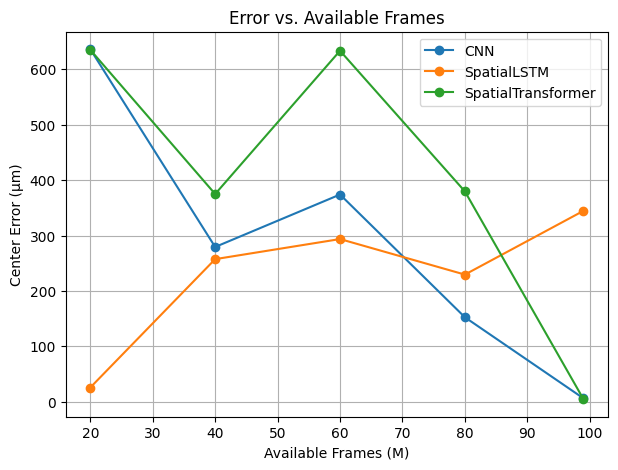

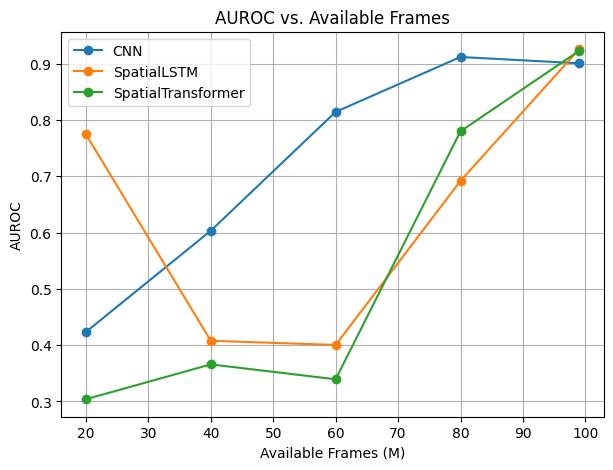

exp2


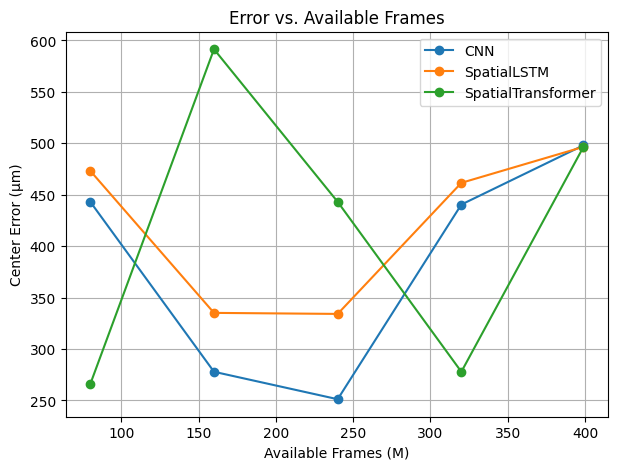

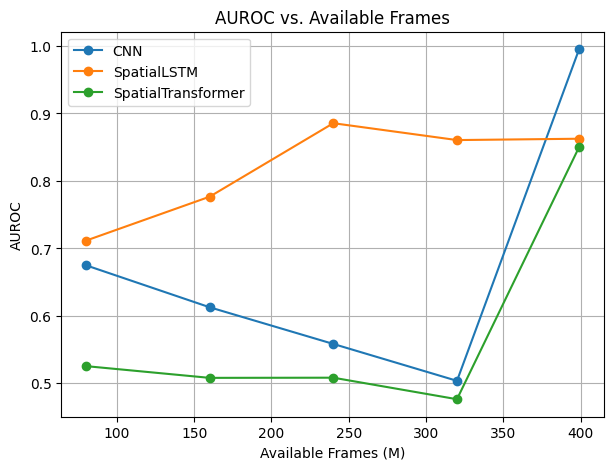

exp3


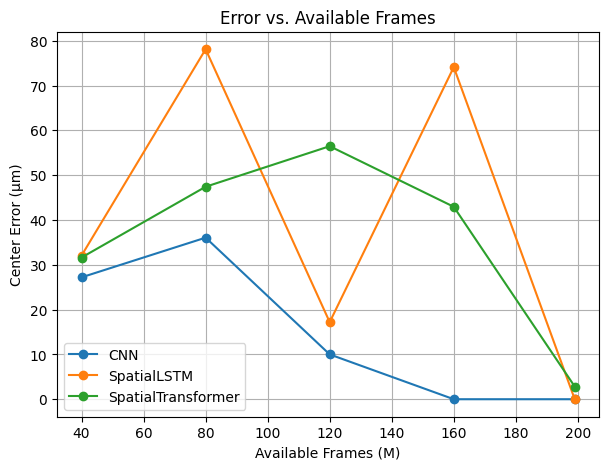

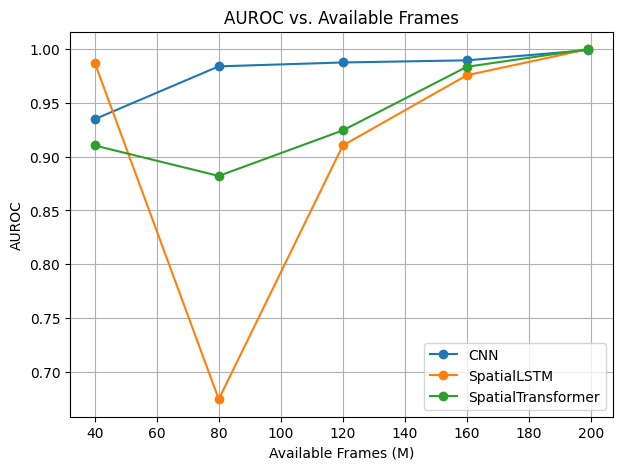

In [28]:
#Error vs. available frames (how soon can you be right?)
import numpy as np
import pandas as pd

@torch.no_grad()
def rollout_future_frames(model, arr_2d, K=8, n_future=10):
    model.eval()
    seq = arr_2d.copy()
    T, H, W = seq.shape
    preds = []
    x_curr = seq[-K:].astype(np.float32)  # (K,H,W)

    for step in range(n_future):
        x_tensor = torch.from_numpy(x_curr[None, :, None, ...]).to(DEVICE)  # (1,K,1,H,W)
        pred = model(x_tensor).cpu().squeeze().numpy()
        pred = np.clip(pred, 0, 1)
        preds.append(pred)
        x_curr = np.concatenate([x_curr[1:], pred[None, ...]], axis=0)

    return np.stack(preds, axis=0)  # (n_future, H, W)


def get_metrics_by_frames(arr_2d,M_list):
    gt = arr_2d[-1]
    H, W = gt.shape

    center_errs = {"CNN": [], "SpatialLSTM": [], "SpatialTransformer": []}
    aurocs       = {"CNN": [], "SpatialLSTM": [], "SpatialTransformer": []}

    for M in M_list:
        print(f"\n=== Training with first {M} frames ===")
        arr_sub = arr_2d[:M]

        print('Training CNN')
        model = TinyCNN(K).to(DEVICE)
        model_cnn = train(model, arr_train=arr_sub, K=K, batch_size=8, epochs=20, lr=1e-3, exclude_last=False)
        pred_seq_cnn = rollout_future_frames(model_cnn, arr_sub, K=K, n_future=len(arr_2d) - M)
        pred_final_cnn = pred_seq_cnn[-1]
        c_err = compute_center_error([pred_final_cnn], gt)
        aroc, _ = compute_spatial_quality([pred_final_cnn], gt)
        center_errs["CNN"].append(c_err)
        aurocs["CNN"].append(aroc)

        print('Training LSTM')
        model = SpatialLSTM(K).to(DEVICE)
        model_lstm = train(model, arr_train=arr_sub, K=K, batch_size=8, epochs=20, lr=1e-3, exclude_last=False)
        pred_seq_lstm = rollout_future_frames(model_lstm, arr_sub, K=K, n_future=len(arr_2d) - M)
        pred_final_lstm = pred_seq_lstm[-1]
        c_err = compute_center_error([pred_final_lstm], gt)
        aroc, _ = compute_spatial_quality([pred_final_lstm], gt)
        center_errs["SpatialLSTM"].append(c_err)
        aurocs["SpatialLSTM"].append(aroc)

        print('Training Transformer')
        model = SpatialTransformer(K).to(DEVICE)
        model_trans = train(model, arr_train=arr_sub, K=K, batch_size=8, epochs=20, lr=1e-3, exclude_last=False)
        pred_seq_trans = rollout_future_frames(model_trans, arr_sub, K=K, n_future=len(arr_2d) - M)
        pred_final_trans = pred_seq_trans[-1]
        c_err = compute_center_error([pred_final_trans], gt)
        aroc, _ = compute_spatial_quality([pred_final_trans], gt)
        center_errs["SpatialTransformer"].append(c_err)
        aurocs["SpatialTransformer"].append(aroc)
    return center_errs,aurocs

def plot_result(center_errs,aurocs,M_list):
  plt.figure(figsize=(7,5))
  for name, vals in center_errs.items():
      plt.plot(M_list, vals, marker='o', label=name)
  plt.xlabel("Available Frames (M)")
  plt.ylabel("Center Error (µm)")
  plt.title("Error vs. Available Frames")
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(7,5))
  for name, vals in aurocs.items():
      plt.plot(M_list, vals, marker='o', label=name)
  plt.xlabel("Available Frames (M)")
  plt.ylabel("AUROC")
  plt.title("AUROC vs. Available Frames")
  plt.legend()
  plt.grid(True)
  plt.show()

center_errs_exp1,aurocs_exp1 = get_metrics_by_frames(arr_2d_exp1,[20,40,60,80,99])
center_errs_exp2,aurocs_exp2 = get_metrics_by_frames(arr_2d_exp2,[80,160,240,320,399])
center_errs_exp3,aurocs_exp3 = get_metrics_by_frames(arr_2d_exp3,[40,80,120,160,199])

print('exp1')
plot_result(center_errs_exp1,aurocs_exp1,[20,40,60,80,99])
print('exp2')
plot_result(center_errs_exp2,aurocs_exp2,[80,160,240,320,399])
print('exp3')
plot_result(center_errs_exp3,aurocs_exp3,[40,80,120,160,199])


The following rolls the three models forward to predict future frames, computes optical flow for the predictions, and shows their motion cues—flow visualizations that reveal how Dicty decides where to go. Taking experiment 1 as an example, the Dicty cells exhibit a general upward movement trend, gradually shifting to the right over time and eventually converging toward the predicted aggregation center. The CNN’s predicted motion further shows that, as time progresses and Dicty approaches its final destination, the magnitude of movement gradually decreases (i.e., the position gradually becomes stable).

(99, 308, 308, 2)
CNN


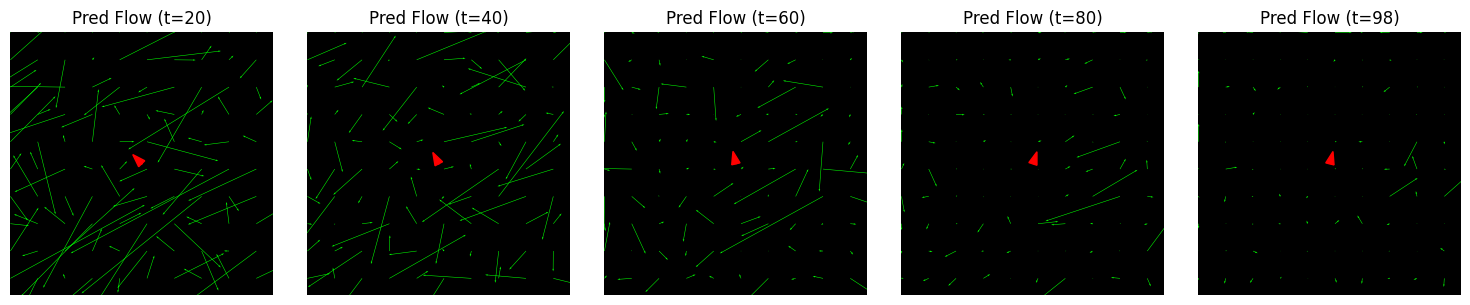

SpatialLSTM


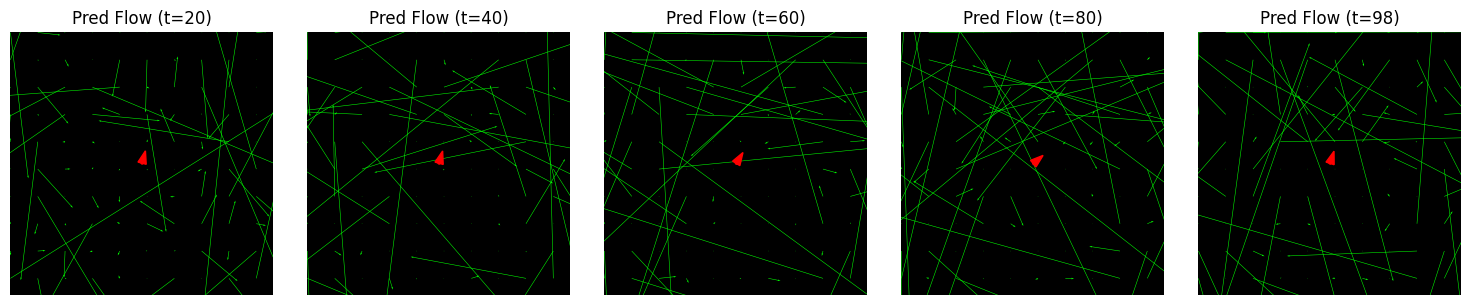

In [17]:
import cv2
import numpy as np

def compute_optical_flow_stack(arr_2d, dt=1):
    T, H, W = arr_2d.shape
    flows = []

    for t in range(T - dt):
        prev = arr_2d[t].astype(np.float32)
        nxt  = arr_2d[t+dt].astype(np.float32)

        prev_n = cv2.normalize(prev, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        nxt_n  = cv2.normalize(nxt,  None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        flow = cv2.calcOpticalFlowFarneback(
            prev_n, nxt_n, None,
            pyr_scale=0.5, levels=3,
            winsize=15, iterations=3,
            poly_n=5, poly_sigma=1.2,
            flags=0
        )  # (H,W,2)
        flows.append(flow)

    return np.stack(flows, axis=0)  # (T-dt,H,W,2)

flows = compute_optical_flow_stack(arr_2d_exp1, dt=1)
print(flows.shape)  # (T-1, H, W, 2)

@torch.no_grad()
def rollout_future_frames(model, arr_2d, K=8, n_future=5):
    model.eval()
    seq = arr_2d.copy()
    T, H, W = seq.shape
    preds = []

    x_curr = seq[-K:].astype(np.float32)
    for step in range(n_future):
        x_tensor = torch.from_numpy(x_curr[None, :, None, ...]).to(DEVICE)
        pred = model(x_tensor).detach().cpu().squeeze().numpy()
        preds.append(pred)
        x_curr = np.concatenate([x_curr[1:], pred[None, ...]], axis=0)

    return np.stack(preds, axis=0)  # (n_future, H, W)



def flow_quiver(arr_true, arr_pred, flows_true, flows_pred,
                t_list=(20, 40, 60, 80, 98),
                step=8, amplify=1.0, scale=0.3, stride=3, show_global=True):

    T_flow = flows_pred.shape[0]
    valid_ts = [t for t in t_list if 0 <= t < T_flow]

    n_plots = len(valid_ts)
    fig, axs = plt.subplots(1, n_plots, figsize=(3 * n_plots, 3))

    if n_plots == 1:
        axs = [axs]

    for ax, t in zip(axs, valid_ts):
        flow_pr = flows_pred[t]        # (H, W, 2)
        H, W = flow_pr.shape[:2]

        ys = np.arange(0, H, step)
        xs = np.arange(0, W, step)
        X, Y = np.meshgrid(xs, ys)

        fx_pr = flow_pr[ys[:, None], xs[None, :], 0] * amplify
        fy_pr = flow_pr[ys[:, None], xs[None, :], 1] * amplify

        Xs, Ys = X[::stride, ::stride], Y[::stride, ::stride]
        fx_pr_s, fy_pr_s = fx_pr[::stride, ::stride], fy_pr[::stride, ::stride]

        ax.imshow(np.zeros((H, W)), cmap='gray')
        ax.quiver(Xs, Ys, fx_pr_s, fy_pr_s,
                  color='lime', scale=scale, width=0.002)
        ax.set_title(f"Pred Flow (t={t})")
        ax.axis('off')

        if show_global:
            mean_pr = flow_pr.reshape(-1, 2).mean(axis=0)
            center = np.array([W/2, H/2])
            ax.arrow(center[0], center[1],
                     mean_pr[0]*50, mean_pr[1]*50,
                     color='red', width=1.5, head_width=10)

    plt.tight_layout()
    plt.show()

print('CNN')
pred_seq = rollout_future_frames(model_cnn_exp1, arr_2d_exp1, K=8, n_future=100)
flows_pred = compute_optical_flow_stack(pred_seq)
flows_true = compute_optical_flow_stack(arr_2d_exp1[-100:])
flow_quiver(arr_2d_exp1[-100:], pred_seq,
            flows_true, flows_pred,
            t_list=[20, 40, 60, 80, 98],
            step=8, amplify=2.0, stride=4, show_global=True)

print('SpatialLSTM')
pred_seq = rollout_future_frames(model_lstm_exp1, arr_2d_exp1, K=8, n_future=100)
flows_pred = compute_optical_flow_stack(pred_seq)
flows_true = compute_optical_flow_stack(arr_2d_exp1[-100:])

flow_quiver(arr_2d_exp1[-100:], pred_seq,
            flows_true, flows_pred,
            t_list=[20, 40, 60, 80, 98],
            step=8, amplify=2.0, stride=4, show_global=True)


### Idea: Adapting VAE-based framework for spatial sequence prediction to model uncertainty (for bonus points)

The previous models produce deterministic predictions for future frames and aggregation centers. However, the motion trajectories of Dicty may exhibit inherent uncertainty, meaning that the outputs should not necessarily be unique. Motivated by this observation, we explore combining a VAE with CNN or Transformer architectures to incorporate uncertainty into spatial sequence prediction.


We begin with the **basic approach** (which did not work). It combines a CNN-based spatial encoder, a Transformer for temporal sequence modeling, and a variational latent space to capture uncertainty in future-frame prediction.

**Spatial Encoding**

Each frame is passed through a lightweight CNN to extract a $D$-dimensional spatial feature vector, producing one feature per frame in the input sequence.

**Temporal Modeling**

The sequence of $K$ encoded features is enriched with a positional embedding and processed by a Transformer encoder. The final token output serves as the sequence representation.

**Variational Latent Space**

Two linear layers compute the mean $\mu$ and log-variance $\log \sigma^2$. A latent sample is drawn via:
$$
z = \mu + \sigma \odot \epsilon,\quad \epsilon \sim \mathscr{N}(0,I)
$$
introducing stochasticity for uncertainty modeling.

**Decoding**

The latent sample is decoded through a linear layer and reshaped to produce the predicted frame.

**Training Objective**

The model optimizes a VAE loss:
$$
\mathscr{L} = \text{MSE}(\hat{x}, x_{\text{target}})
+ D_{\text{KL}}\big(q(z|x) \,\|\, p(z)\big),
$$
balancing reconstruction accuracy with latent regularization.

At inference time, **multiple predictions can be generated by sampling from the latent space**, allowing the model to express diverse plausible futures and quantify uncertainty through variance across sampled outputs.


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class CNNEncoder(nn.Module):
    def __init__(self, D=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8))
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*8*8, D)

    def forward(self, x):  # x: (B*T, 1, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        return self.fc(x)  # (B*T, D)


class TransformerVAE(nn.Module):
    def __init__(self, K, H, W, D=128, latent_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.H, self.W = H, W
        self.K = K
        self.cnn_encoder = CNNEncoder(D)
        self.pos_embed = nn.Parameter(torch.randn(1, K, D))

        encoder_layer = nn.TransformerEncoderLayer(d_model=D, nhead=num_heads, batch_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc_mu = nn.Linear(D, latent_dim)
        self.fc_logvar = nn.Linear(D, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, H*W),
            nn.Sigmoid()  # output in [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):  # x: (B,K,1,H,W)
        B, K, C, H, W = x.shape
        x = x.reshape(B*K, 1, H, W)
        z = self.cnn_encoder(x).reshape(B, K, -1)  # (B, K, D)

        z = z + self.pos_embed[:, :K]              # (1,K,D)
        z = z.permute(1, 0, 2)                     # (K, B, D) for Transformer
        z = self.transformer(z)[-1]                # (B, D)

        mu = self.fc_mu(z)                         # (B, latent_dim)
        logvar = self.fc_logvar(z)                 # (B, latent_dim)
        z_sample = self.reparameterize(mu, logvar) # (B, latent_dim)

        out = self.decoder(z_sample)               # (B, H*W)
        out = out.view(B, 1, self.H, self.W)       # (B,1,H,W)
        return out, mu, logvar


def vae_loss(recon, target, mu, logvar):
    """
    recon: (B,1,H,W)
    target: (B,1,H,W)
    """
    recon_loss = F.mse_loss(recon, target, reduction='mean')
    # KL per batch
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / target.size(0)
    return recon_loss + kl, recon_loss, kl


from torch.utils.data import DataLoader, random_split

def train_vae(arr_train, K=8, batch_size=8, epochs=30, lr=1e-3,
              D=128, latent_dim=64, num_heads=4, num_layers=2):
    arr = arr_train
    T, H, W = arr.shape

    ds = WindowedNextFrame(arr, K=K)
    n_tr = int(0.7*len(ds)); n_val = int(0.15*len(ds)); n_te = len(ds)-n_tr-n_val
    tr, val, te = random_split(ds, [n_tr, n_val, n_te],
                               generator=torch.Generator().manual_seed(0))

    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size*2)

    model = TransformerVAE(K, H, W, D=D, latent_dim=latent_dim,
                           num_heads=num_heads, num_layers=num_layers).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = np.inf
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        tr_loss_tot = 0.0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)  # xb:(B,K,1,H,W), yb:(B,1,H,W)
            opt.zero_grad()
            recon, mu, logvar = model(xb)
            loss, recon_l, kl_l = vae_loss(recon, yb, mu, logvar)
            loss.backward()
            opt.step()
            tr_loss_tot += loss.item() * xb.size(0)
        tr_loss = tr_loss_tot / len(tr)

        model.eval()
        val_loss_tot = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                recon, mu, logvar = model(xb)
                loss, _, _ = vae_loss(recon, yb, mu, logvar)
                val_loss_tot += loss.item() * xb.size(0)
        val_loss = val_loss_tot / len(val)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}

        if ep % 5 == 0:
            print(f"[VAE] Epoch {ep:02d}  train {tr_loss:.5f}  val {val_loss:.5f}")

    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
    return model


@torch.no_grad()
def predict_vae_final(model, arr_2d, K=8, n_samples=20):
    model.eval()
    x_last = arr_2d[-K:].astype(np.float32)   # (K,H,W)
    x_last = x_last[:, None, ...]            # (K,1,H,W)
    x_last = torch.from_numpy(x_last[None]).to(DEVICE)  # (1,K,1,H,W)

    preds = []
    for _ in range(n_samples):
        recon, mu, logvar = model(x_last)
        pred = recon.detach().cpu().squeeze().numpy()   # (H,W)
        preds.append(pred)

    preds = np.stack(preds, axis=0)      # (n_samples,H,W)
    mean_pred = preds.mean(axis=0)
    std_pred  = preds.std(axis=0)
    return mean_pred, std_pred, preds


def eval_vae_on_test(model, arr_test, K=8, n_samples=20):
    mean_pred, std_pred, samples = predict_vae_final(model, arr_test, K=K, n_samples=n_samples)
    gt = arr_test[-1]

    center_err = compute_center_error([mean_pred], gt)
    auroc, ap  = compute_spatial_quality([mean_pred], gt)

    print(f"VAE  CenterErr={center_err:.3f} µm, AUROC={auroc:.3f}, AP={ap:.3f}")
    return center_err, auroc, ap, mean_pred, std_pred, samples



def plot_vae_results(gt, mean_pred, std_pred):
    gt_pt   = get_brightest_point(gt)
    pred_pt = get_brightest_point(mean_pred)

    fig, axs = plt.subplots(1, 3, figsize=(14,4))

    # GT
    axs[0].imshow(gt, cmap='gray')
    axs[0].scatter(gt_pt[1], gt_pt[0], c='red', s=60, marker='o', label='GT center')
    axs[0].set_title("Ground Truth (final frame)")
    axs[0].axis('off')
    axs[0].legend(loc='upper right')

    # Predicted mean
    axs[1].imshow(mean_pred, cmap='gray')
    axs[1].scatter(pred_pt[1], pred_pt[0], c='lime', s=60, marker='x', label='Pred center')
    axs[1].set_title("VAE mean prediction")
    axs[1].axis('off')
    axs[1].legend(loc='upper right')

    # Uncertainty (std)
    im = axs[2].imshow(std_pred, cmap='magma')
    axs[2].set_title("VAE predictive uncertainty (std)")
    axs[2].axis('off')
    plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def predict_conv_vae(model, arr_2d, K=8, n_samples=20):
    model.eval()
    x_last = arr_2d[-K:, None, ...].astype(np.float32)
    x_last = torch.from_numpy(x_last[None]).to(DEVICE)
    preds = []
    for _ in range(n_samples):
        recon, mu, logvar = model(x_last)
        preds.append(recon.detach().cpu().squeeze().numpy())
    preds = np.stack(preds, 0)
    return preds.mean(0), preds.std(0), preds


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[VAE] Epoch 05  train 0.99007  val 0.27936
[VAE] Epoch 10  train 0.59713  val 0.23059
[VAE] Epoch 15  train 0.40859  val 0.23141
[VAE] Epoch 20  train 0.25094  val 0.19433
[VAE] Epoch 25  train 0.19303  val 0.18359
[VAE] Epoch 30  train 0.16890  val 0.16145


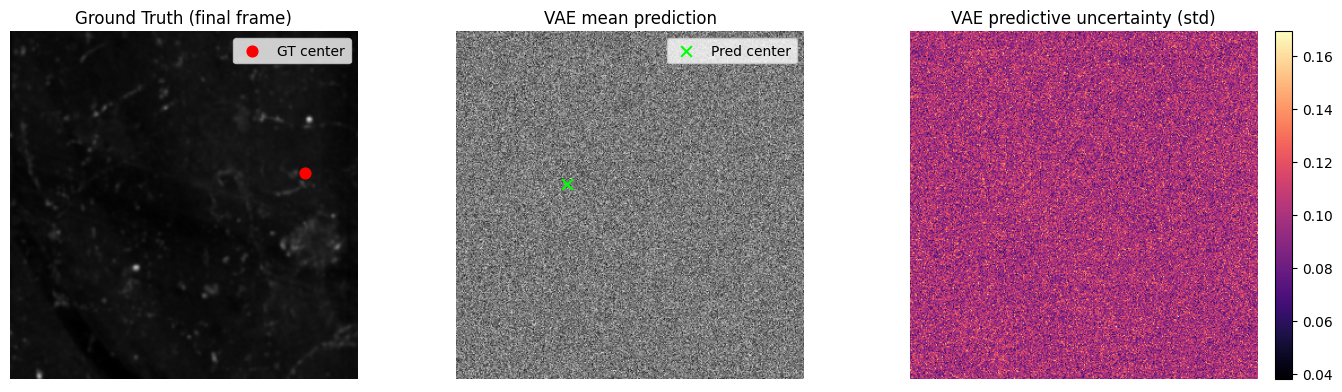

In [30]:
vae_model = train_vae(arr_2d_exp1, K=K, batch_size=8, epochs=30, lr=1e-3)
gt = arr_2d_exp1[-1]
mean_pred, std_pred, samples = predict_conv_vae(vae_model, arr_2d_exp1, K=8, n_samples=20)
plot_vae_results(gt, mean_pred, std_pred)

From the visualizations above, we see that the samples generated and reconstructed by the VAE **collapse into random noise**, indicating that the model fails to learn any meaningful spatial structure or temporal evolution.

To address this issue, we draw inspiration from the successful designs of the SpatialLSTM and SpatialTransformer models and introduce the following improvements:

1. **Grid-based spatial downsampling and upsampling**
   - The new encoder extracts both a full-resolution feature map and a coarse grid representation via adaptive pooling, while the decoder reconstructs images after upsampling.  
   - This preserves spatial patterns and prevents the model from collapsing into noise.

2. **Fusion with the most recent frame**
   - The decoder optionally conditions on the feature map of the last input frame. This mirrors the successful strategy used in SpatialLSTM and SpatialTransformer.

3. **Improved VAE training with KL annealing**
   - A scheduled KL-weight (`beta`) gradually increases over epochs, preventing early latent collapse.  
   - This helps the model learn a meaningful stochastic latent space and supports multi-sample uncertainty estimation.

4. **Conditional convolutional decoder**
   - Instead of a single linear decoder, the new design generates images using convolutional layers conditioned on the latent code.  


From the visualizations, we observe that for all three experiments, **the improved VAE produces sample-averaged predictions that closely match the true last frame and accurately capture the aggregation center**. Moreover, the per-pixel standard deviation across samples exhibits clear spatial variation, indicating that the model successfully **reflects different levels of uncertainty at different locations**. Together, these results demonstrate that the model achieves the intended goal of modeling uncertainty in future-frame and aggregation center predictions.


exp1
[ConvVAE] Epoch 05  tr=30.39388  val=20.20713
[ConvVAE] Epoch 10  tr=13.92405  val=7.38947
[ConvVAE] Epoch 15  tr=8.70311  val=6.22627
[ConvVAE] Epoch 20  tr=6.20323  val=5.85221
[ConvVAE] Epoch 25  tr=5.74707  val=5.77351
[ConvVAE] Epoch 30  tr=5.57273  val=5.66049


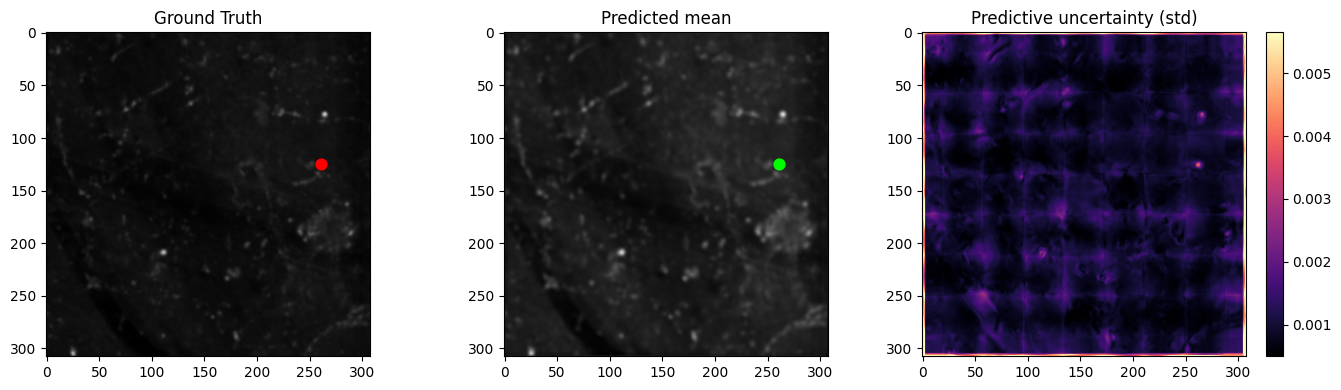

exp2
[ConvVAE] Epoch 05  tr=20.87643  val=18.58103
[ConvVAE] Epoch 10  tr=18.54233  val=17.62133
[ConvVAE] Epoch 15  tr=18.32986  val=17.53908
[ConvVAE] Epoch 20  tr=18.14111  val=17.70337
[ConvVAE] Epoch 25  tr=18.48504  val=20.44666
[ConvVAE] Epoch 30  tr=19.54247  val=17.79473


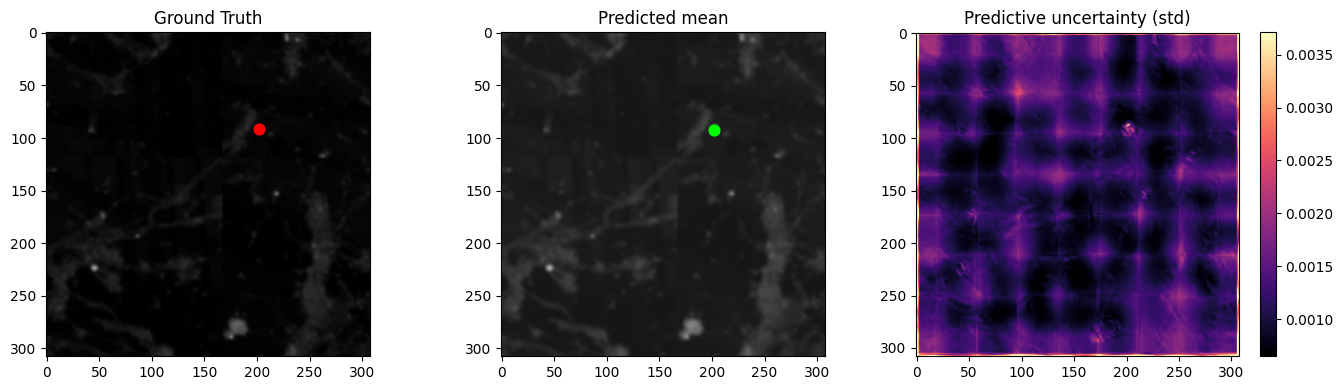

exp3
[ConvVAE] Epoch 05  tr=5.51304  val=2.23310
[ConvVAE] Epoch 10  tr=1.66733  val=0.97337
[ConvVAE] Epoch 15  tr=0.99562  val=0.82508
[ConvVAE] Epoch 20  tr=0.90805  val=0.76369
[ConvVAE] Epoch 25  tr=0.88126  val=0.75194
[ConvVAE] Epoch 30  tr=0.83363  val=0.69985


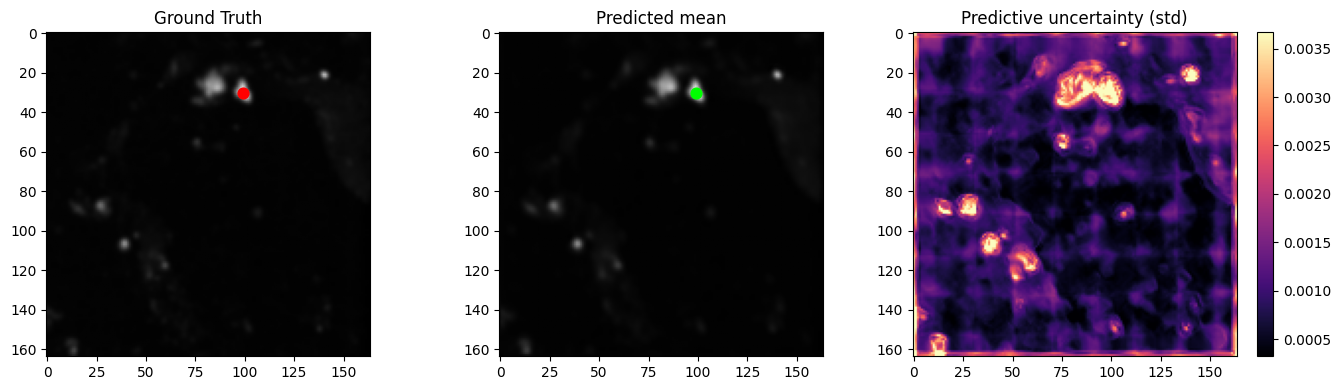

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np

class FrameEncoderWithGrid(nn.Module):
    def __init__(self, H, W, D=128, Cenc=32, grid=(8,8)):
        super().__init__()
        self.Cenc = Cenc
        self.gH, self.gW = grid
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, Cenc, 3, padding=1), nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((self.gH, self.gW))
        self.proj = nn.Linear(Cenc * self.gH * self.gW, D)

    def forward(self, x):  # (B,1,H,W)
        f_map = self.backbone(x)
        f_grid = self.pool(f_map)
        f_vec = self.proj(f_grid.flatten(start_dim=1))
        return f_map, f_vec


class ConditionalConvDecoder(nn.Module):
    def __init__(self, latent_dim, H, W, Cenc=32, grid=(8,8), z_channels=128, fuse_last_frame=True):
        super().__init__()
        self.H, self.W = H, W
        self.gH, self.gW = grid
        self.Cz = z_channels
        self.Cenc = Cenc
        self.fuse_last = fuse_last_frame

        self.fc = nn.Linear(latent_dim, self.Cz * self.gH * self.gW)
        dec_in_ch = self.Cz + (self.Cenc if self.fuse_last else 0)
        self.decoder = nn.Sequential(
            nn.Conv2d(dec_in_ch, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, z, f_last_map):
        B = z.size(0)
        z_grid = self.fc(z).view(B, self.Cz, self.gH, self.gW)
        z_up = F.interpolate(z_grid, size=(self.H, self.W), mode='bilinear', align_corners=False)
        dec_in = torch.cat([z_up, f_last_map], dim=1) if self.fuse_last else z_up
        return self.decoder(dec_in)


class ConvTransformerVAE(nn.Module):
    def __init__(self, K, H, W, D=128, latent_dim=128,
                 num_heads=4, num_layers=2, grid=(8,8),
                 Cenc=32, z_channels=128, fuse_last_frame=True, use_time_pos=True):
        super().__init__()
        self.H, self.W, self.K = H, W, K
        self.use_time_pos = use_time_pos
        self.frame_encoder = FrameEncoderWithGrid(H, W, D=D, Cenc=Cenc, grid=grid)
        self.pos_embed = nn.Parameter(torch.randn(1, K, D))
        enc_layer = nn.TransformerEncoderLayer(d_model=D, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc_mu = nn.Linear(D, latent_dim)
        self.fc_logvar = nn.Linear(D, latent_dim)
        self.decoder = ConditionalConvDecoder(latent_dim, H, W, Cenc=Cenc,
                                              grid=grid, z_channels=z_channels,
                                              fuse_last_frame=fuse_last_frame)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, x):  # (B,K,1,H,W)
        B, K, _, H, W = x.shape
        f_last_map, tokens = None, []
        for t in range(K):
            f_map, f_vec = self.frame_encoder(x[:, t])
            tokens.append(f_vec)
            if t == K - 1:
                f_last_map = f_map
        z_seq = torch.stack(tokens, 1)
        if self.use_time_pos:
            z_seq = z_seq + self.pos_embed[:, :K, :]
        z_ctx = self.transformer(z_seq)[:, -1, :]
        mu, logvar = self.fc_mu(z_ctx), self.fc_logvar(z_ctx)
        z_sample = self.reparameterize(mu, logvar)
        out = self.decoder(z_sample, f_last_map)
        return out, mu, logvar

def vae_loss(recon_logits, target, mu, logvar, beta=0.5, use_mse=True):
    B = target.size(0)
    if use_mse:
        recon_l = F.mse_loss(recon_logits, target, reduction='none').view(B, -1).sum(1).mean()
    else:
        recon_l = F.binary_cross_entropy_with_logits(recon_logits, target, reduction='none'
                    ).view(B, -1).sum(1).mean()

    kl = 0.5 * (-1 - logvar + mu.pow(2) + logvar.exp()).view(B, -1).sum(1).mean()
    return recon_l + beta * kl, recon_l, kl

def train_conv_vae(arr_train, K=8, batch_size=8, epochs=30, lr=1e-3, beta_max=5.0):
    T, H, W = arr_train.shape
    ds = WindowedNextFrame(arr_train, K)
    n_tr = int(0.7 * len(ds)); n_val = int(0.15 * len(ds)); n_te = len(ds) - n_tr - n_val
    tr, val, te = random_split(ds, [n_tr, n_val, n_te], generator=torch.Generator().manual_seed(0))
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size*2)

    model = ConvTransformerVAE(K, H, W).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_state, best_val = None, np.inf

    for ep in range(1, epochs + 1):
        kl_weight = min(1.0, ep / 10.0)
        model.train(); tr_loss = 0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            recon, mu, logvar = model(xb)
            loss, recon_l, kl = vae_loss(recon, yb, mu, logvar, beta=beta_max * kl_weight)
            loss.backward(); opt.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(tr)

        model.eval(); val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                recon, mu, logvar = model(xb)
                loss, _, _ = vae_loss(recon, yb, mu, logvar)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        if ep % 5 == 0:
            print(f"[ConvVAE] Epoch {ep:02d}  tr={tr_loss:.5f}  val={val_loss:.5f}")

    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model

def plot_vae_results(gt, mean_pred, std_pred):
    gt_pt = get_brightest_point(gt)
    pred_pt = get_brightest_point(mean_pred)
    mean_pred = np.clip(mean_pred, 0, 1)
    std_pred = np.clip(std_pred, 0, 1)

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    axs[0].imshow(gt, cmap='gray')
    axs[0].scatter(gt_pt[1], gt_pt[0], c='r', s=60)
    axs[0].set_title("Ground Truth")

    axs[1].imshow(mean_pred, cmap='gray')
    axs[1].scatter(pred_pt[1], pred_pt[0], c='lime', s=60)
    axs[1].set_title("Predicted mean")
    vmin = np.percentile(std_pred, 1)
    vmax = np.percentile(std_pred, 99)
    im = axs[2].imshow(std_pred, cmap='magma', vmin=vmin, vmax=vmax)
    axs[2].set_title("Predictive uncertainty (std)")

    plt.colorbar(im, ax=axs[2])
    plt.tight_layout()
    plt.show()

print('exp1')
vae = train_conv_vae(arr_2d_exp1, K=8, epochs=30, lr=1e-3, beta_max=5.0)
mean_pred, std_pred, samples = predict_conv_vae(vae, arr_2d_exp1, K=8, n_samples=20)
gt = arr_2d_exp1[-1]
plot_vae_results(gt, mean_pred, std_pred)

print('exp2')
vae = train_conv_vae(arr_2d_exp2, K=8, epochs=30, lr=1e-3, beta_max=5.0)
mean_pred, std_pred, samples = predict_conv_vae(vae, arr_2d_exp2, K=8, n_samples=20)
gt = arr_2d_exp2[-1]
plot_vae_results(gt, mean_pred, std_pred)

print('exp3')
vae = train_conv_vae(arr_2d_exp3, K=8, epochs=30, lr=1e-3, beta_max=5.0)
mean_pred, std_pred, samples = predict_conv_vae(vae, arr_2d_exp3, K=8, n_samples=20)
gt = arr_2d_exp3[-1]
plot_vae_results(gt, mean_pred, std_pred)

### Conclusion

In this project, we developed a series of models for predicting Dicty aggregation dynamics, with a particular focus on forecasting the future aggregation center while preserving spatial information throughout temporal modeling. We conducted extensive baseline comparisons, ablation studies, robustness checks, and qualitative visualizations, and finally explored a VAE-based approach to capture predictive uncertainty. The main findings are as follows:

1. **Superior spatiotemporal modeling:**  
   Both SpatialLSTM and SpatialTransformer effectively integrate temporal evolution with spatial structure, achieving consistently better performance across all metrics compared to the baseline CNN.

2. **Importance of spatial structure and recent-information fusion:**  
   Ablation studies demonstrate that retaining spatial information is essential—without it, predictions lose spatial specificity. Additionally, fusing information from the most recent frame significantly enhances prediction accuracy.

3. **Robustness under resolution degradation:**  
   When evaluated on subsampled test data, all models maintain relatively stable performance, with SpatialLSTM and SpatialTransformer showing stronger robustness than CNN.

4. **Sensitivity to accumulated error:**  
   When predicting the final frame using only the first few frames, all models exhibit noticeable performance degradation due to error accumulation (SpatialLSTM degrades more slowly but still significantly), indicating high sensitivity to multi-step rollouts.

5. **Modeling uncertainty via improved VAE design:**  
   A naive combination of CNN encoders, Transformers, and VAE collapses into random noise. However, after incorporating strategies including spatial downsampling/upsampling and KL annealing, the improved mdoel is able to reconstruct plausible future frames, recover the aggregation center, and provide meaningful spatial uncertainty estimates.

Overall, this study highlights the importance of jointly modeling spatial structure and temporal dynamics for Dicty aggregation prediction, and demonstrates that uncertainty-aware generative modeling can further enhance interpretability and reliability in future-frame forecasting tasks.



### Future Work
1. **Mitigating sensitivity to accumulated prediction error**  
   - Explore multi-step training objectives (predicting several future frames rather than only the next one) to reduce overreliance on the last input frame.  
   - Incorporate scheduled sampling or partial teacher forcing so that the model gradually becomes more robust to its own rollout errors.

2. **Improving the use of temporal information**  
   - Investigate temporal architectures with longer-range memory, such as gated attention or temporal convolutional modules, and increasing the length of the input sequence.
   - The current positional embedding did not yield clear improvements. Future work could explore alternative mechanisms for encoding temporal order, such as rotary positional embeddings (RoPE).

3. **Richer spatial representations and decoding mechanisms**  
   - Explore hierarchical or multi-scale encoders and decoders to better capture both coarse and fine spatial patterns in early and late aggregation stages.  
   - Consider integrating spatial priors or biologically inspired constraints to guide more realistic frame evolution.

4. **Enhancing uncertainty estimation & guiding active acquisition**  
   - Develop more expressive generative components (e.g., diffusion models or autoregressive VAEs) to better capture multimodal future outcomes.  
   - Use the predicted uncertainty maps to guide active acquisition, identifying frames or regions where additional imaging would most reduce predictive ambiguity.
